In [12]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt 
#import cv2 as cv

from keras.layers import Conv2D, Input, LeakyReLU, Dense, Activation, Flatten, Dropout, MaxPool2D
from keras import models
from keras.optimizers import Adam,RMSprop 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import pickle

%matplotlib inline

Using TensorFlow backend.
/Users/frito/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/frito/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/frito/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/frito/opt/anaconda3/lib/python3.7/sit

Utilizou-ser o dataset proveniente do IMDB/wikipedia:
https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/


### load atributos (target)

In [13]:
#Apos pre extração de um ficheiro mat que possuia os dados relativos a cada imagem, gerou se um csv com os valores de output esperados da rede para cada figura
features=pd.read_csv('/Users/frito/Downloads/result.csv', header=None)
#Rename das colunas para os campos
colunas=['foto','idade','genero']
features.columns=colunas 

In [14]:
# traNSFORMAÇAO DO NOME DA IMAGEM EM INDEX PARA POSTERIOR ANEXAÇAO DAS INTENSIDADOS DOS PIXEIS COMO FEATURES
features=features.set_index('foto')
features.head()

idade  genero
foto                                          
17/10000217_1981-05-05_2009.jpg     28     1.0
48/10000548_1925-04-04_1964.jpg     39     1.0
12/100012_1948-07-03_2008.jpg       60     1.0
65/10001965_1930-05-23_1961.jpg     31     1.0
16/10002116_1971-05-31_2012.jpg     41     0.0

####  avaliaçao desta componente do dataset

In [72]:
features.isna().sum()

idade        0
genero    2643
dtype: int64

In [75]:
(features.idade < 0).sum()

1198

#### correçao de missing values e valores nao logicos

In [77]:
print(features.shape)
features=features.dropna()
print(features.shape)

(62328, 2)
(59685, 2)


In [82]:
features=features[features.idade > 0] 
print(features.shape)
features=features[features.idade < 100]
print(features.shape)

(58460, 2)
(57932, 2)


#### analise das distribuiçoes das features

In [83]:
print(features.genero.value_counts())

1.0    45387
0.0    12545
Name: genero, dtype: int64


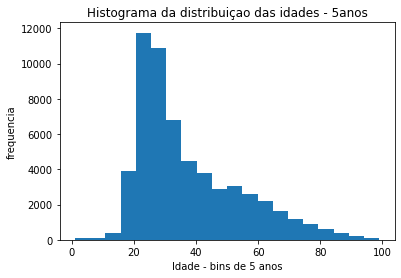

In [89]:
x = features.idade
plt.hist(x, bins=20)
plt.ylabel('frequencia')
plt.xlabel('Idade - bins de 5 anos')
plt.title('Histograma da distribuiçao das idades')
plt.show()

In [84]:
print(features.idade.unique())
features.idade.value_counts()

[28 39 60 31 41 52 34 78 61 29 42 36 23 38 25 32 37 19 51 33 30 13 27 68
 24 49 46 72 53 47 57 55 58 54 67 79 50 22 26 48 44 63 62 73 71 18 21 59
 66 70 45 56 81 35 43 69 74 20 40 77 95 17 16 76 65  5 75 82 15 83 85 64
 80 96  4 84 86 90 88 93 91 14 87 94 89 10  8  1 99 92 98  3  7  9 12  2
 11 97  6]


23    2651
24    2535
26    2515
25    2456
27    2342
      ... 
98      15
7       14
5       13
6       13
2       10
Name: idade, Length: 99, dtype: int64

### Load imagem

In [29]:
import os

path = '.'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))

for f in files:
    print(f[2:])

61/19242061_1982-08-16_2009.jpg
61/2399661_1977-09-02_2008.jpg
61/9494361_1962-04-21_1994.jpg
61/44438061_1937-11-14_1969.jpg
61/37699961_1890-12-11_1947.jpg
61/41899761_1989-10-06_2012.jpg
61/8794261_1970-10-06_2011.jpg
61/37117161_1956-11-28_1986.jpg
61/9707061_1986-11-12_2006.jpg
61/2265561_1987-08-25_2011.jpg
61/46518261_1922-10-16_1948.jpg
61/15330561_1943-08-11_2002.jpg
61/194961_1967-05-29_2012.jpg
61/17683961_1964-03-17_2014.jpg
61/2075561_1966-06-14_2010.jpg
61/39957661_1988-07-23_2015.jpg
61/19045461_1977-08-28_2013.jpg
61/28843761_1979-09-08_1996.jpg
61/24439461_1982-05-29_2013.jpg
61/31026761_1984-04-04_2015.jpg
61/22156261_1992-10-16_2011.jpg
61/42197061_1991-10-27_2009.jpg
61/32692161_1984-07-20_2011.jpg
61/34933261_1990-07-15_2012.jpg
61/4829861_1986-04-27_2015.jpg
61/2483261_1981-02-19_2012.jpg
61/22753061_1899-11-09_1940.jpg
61/20410261_1982-05-01_2015.jpg
61/97561_1984-10-27_2013.jpg
61/4293661_1967-05-16_1995.jpg
61/36075861_1983-09-23_2014.jpg
61/42168061_1996-06-01

59/28564459_1993-04-20_2013.jpg
59/34758359_1892-05-15_2004.jpg
59/272859_1977-07-24_2007.jpg
59/36873059_1989-08-02_2015.jpg
59/1769759_1948-11-06_2006.jpg
59/13819859_1958-03-19_2012.jpg
59/41103159_1960-04-04_1980.jpg
59/6440759_1972-05-07_2013.jpg
59/12218559_1981-05-13_2015.jpg
59/929659_1980-04-28_2014.jpg
59/1855159_1982-02-04_2008.jpg
59/171859_1903-06-21_1955.jpg
59/6143259_1983-06-10_2009.jpg
59/6437759_1987-07-03_2015.jpg
59/21302959_1933-07-17_1949.jpg
59/16343559_1988-10-12_2006.jpg
59/5238659_1980-06-20_2010.jpg
59/36301359_1989-12-04_2013.jpg
59/26877159_1989-10-05_2011.jpg
59/28753159_1996-09-01_2013.jpg
59/22962359_1951-03-01_1972.jpg
59/39267459_1989-02-27_2014.jpg
59/25529159_1987-11-23_2010.jpg
59/6041459_1955-04-05_2011.jpg
59/641959_1965-12-21_2012.jpg
59/44714259_1993-11-15_2015.jpg
59/38870159_1944-06-08_1965.jpg
59/33599759_1991-03-11_2014.jpg
59/13276759_1982-01-13_2009.jpg
59/1643259_1923-10-13_1961.jpg
59/7123359_1931-06-26_2014.jpg
59/1975259_1970-08-23_201

66/347766_1950-12-18_2010.jpg
66/16949866_1979-11-08_2013.jpg
66/47055766_1947-01-17_1964.jpg
66/29638066_1985-04-19_2011.jpg
66/41884366_1992-02-20_2014.jpg
66/35064666_1984-09-18_2013.jpg
66/21034866_1961-11-07_2013.jpg
66/1991766_1952-12-10_2010.jpg
66/11287466_1966-08-07_2012.jpg
66/41399266_1991-09-09_2013.jpg
66/14905666_1986-09-09_2008.jpg
66/1964066_1948-09-20_1996.jpg
66/440866_1972-12-13_2008.jpg
66/2884466_1970-08-08_1996.jpg
66/6554466_1955-01-08_2012.jpg
66/43130866_1993-09-12_2014.jpg
66/11141566_1984-06-09_2010.jpg
66/1828666_1954-11-12_2011.jpg
66/17676866_1987-06-16_2010.jpg
66/36319366_1986-06-10_2012.jpg
66/2722166_1903-01-06_1951.jpg
66/9969066_1924-02-27_2003.jpg
66/9455866_1989-02-23_2010.jpg
66/161366_1934-01-20_2010.jpg
66/15680166_1957-06-27_1950.jpg
66/5508766_1977-03-16_2010.jpg
66/21589166_1923-06-04_1948.jpg
66/46662866_1987-05-05_2004.jpg
66/1059566_1980-04-18_2012.jpg
66/38944166_1914-11-14_1941.jpg
66/34169266_1989-12-08_2011.jpg
66/35278866_1988-05-06_1

57/7050057_1970-06-28_2013.jpg
57/38972957_1970-03-30_2010.jpg
57/38437257_1918-10-19_1942.jpg
57/2251257_1931-03-23_1964.jpg
57/330857_1939-05-04_2005.jpg
57/25450657_1959-08-19_2012.jpg
57/3957357_1966-10-09_2009.jpg
57/16094657_1940-12-29_1940.jpg
57/161257_1966-04-09_2014.jpg
57/3007157_1930-10-11_2010.jpg
57/396657_1926-07-09_1963.jpg
57/25418957_1986-11-20_2010.jpg
57/10102057_1913-09-28_1943.jpg
57/40974057_1993-07-20_2014.jpg
57/10705257_1978-12-03_2012.jpg
57/4948457_1983-02-15_2011.jpg
57/44126757_1920-12-06_1945.jpg
57/5008457_1987-05-08_2014.jpg
57/1283357_1973-04-18_2006.jpg
57/2165157_1961-03-19_2010.jpg
57/799357_1960-04-08_2007.jpg
57/98957_1954-07-23_2005.jpg
57/33870457_1989-09-05_2010.jpg
57/16132257_1949-04-16_2011.jpg
57/238157_1953-05-25_2006.jpg
57/14083557_1926-02-28_1955.jpg
57/37252657_1988-10-17_2013.jpg
57/2229657_1965-09-05_2012.jpg
57/22349257_1967-08-22_2011.jpg
57/25372457_1988-03-31_2010.jpg
57/271857_1967-07-26_2011.jpg
57/43769457_1994-10-31_2014.jpg


04/13197504_1965-03-15_2008.jpg
04/5610704_1984-10-23_2012.jpg
04/1623304_1985-07-25_2011.jpg
04/45701004_1994-05-14_2015.jpg
04/27358204_1973-11-30_2014.jpg
04/374904_1930-04-25_2008.jpg
04/6330404_1931-08-15_1973.jpg
04/24340304_1993-08-24_2015.jpg
04/9831104_1978-10-18_2010.jpg
04/8513104_1962-09-12_2014.jpg
04/5268504_1967-08-09_2005.jpg
04/39513904_1958-08-04_2013.jpg
04/45695004_1982-02-02_2005.jpg
04/220604_1958-09-03_2008.jpg
04/41748004_1998-04-26_2014.jpg
04/3468104_1981-01-02_2012.jpg
04/3716504_1979-12-25_2003.jpg
04/17198804_1984-06-27_2009.jpg
04/28285404_1986-09-18_2012.jpg
04/308404_1947-10-09_1965.jpg
04/4387104_1982-08-20_2013.jpg
04/36634504_1992-07-08_2013.jpg
04/46177304_1966-11-06_2013.jpg
04/2299404_1946-12-08_1968.jpg
04/13266004_1987-05-27_2014.jpg
04/8627604_1974-10-24_2007.jpg
04/14351904_1991-07-05_2014.jpg
04/2934404_1925-12-03_1953.jpg
04/40044104_1984-04-03_2013.jpg
04/8757304_1782-07-28_2012.jpg
04/882504_1949-03-05_2009.jpg
04/40436204_1961-10-10_2009.j

69/11612269_1981-01-22_2010.jpg
69/7630469_1971-01-08_2009.jpg
69/3090269_1967-04-07_2008.jpg
69/21326869_1979-09-05_2008.jpg
69/19662369_1991-04-24_2008.jpg
69/2642769_1940-03-30_2013.jpg
69/3265269_1913-02-15_1987.jpg
69/32532469_1990-08-23_2014.jpg
69/4923069_1972-07-06_2008.jpg
69/882769_1981-10-09_2006.jpg
69/18760369_1944-04-03_1966.jpg
69/41052069_1949-03-30_1979.jpg
69/2928169_1938-05-15_2010.jpg
69/12776169_1952-08-16_2010.jpg
69/503169_1925-09-17_2005.jpg
69/34703169_1965-03-02_2008.jpg
69/18480869_1877-09-25_2000.jpg
69/3508369_1982-01-05_2010.jpg
69/23807669_1984-03-30_2008.jpg
69/13533169_1948-09-10_1969.jpg
69/12791069_1949-07-13_1940.jpg
69/7041769_1986-06-30_2006.jpg
69/20589469_1961-05-13_2005.jpg
69/15775769_1924-05-21_1948.jpg
69/8072569_1984-07-11_2010.jpg
69/39152069_1988-09-18_2010.jpg
69/36668769_1993-05-27_2012.jpg
69/1636269_1982-10-06_2007.jpg
69/31582269_1926-02-08_1984.jpg
69/167969_1933-05-14_2011.jpg
69/2379269_1963-12-11_2013.jpg
69/10992169_1969-08-19_20

58/1762258_1982-04-15_2013.jpg
58/37724258_1968-04-14_2006.jpg
58/12353958_1951-09-28_2009.jpg
58/1142258_1955-05-26_2005.jpg
58/26384158_1988-10-18_2010.jpg
58/3932158_1951-06-06_2007.jpg
58/1894358_1969-04-18_2010.jpg
58/18896158_1968-01-01_2014.jpg
58/5277058_1977-10-20_2009.jpg
58/5638258_1907-12-09_1973.jpg
58/9702658_1985-12-02_2009.jpg
58/42662358_1938-04-12_1966.jpg
58/3030158_1939-01-13_2007.jpg
58/10340158_1983-12-07_2011.jpg
58/38408158_1966-03-25_1987.jpg
58/41439358_1972-09-11_2010.jpg
58/26071858_1991-05-30_2014.jpg
58/28616958_1965-09-10_1992.jpg
58/1868058_1935-11-03_2005.jpg
58/262458_1978-05-22_2009.jpg
58/42948458_1989-05-28_2013.jpg
58/18508258_1922-01-15_1973.jpg
58/4506758_1889-07-13_1940.jpg
58/46382258_1926-10-30_1948.jpg
58/3261858_1963-01-10_1978.jpg
58/32550458_1986-01-07_2012.jpg
58/344258_1929-06-20_1989.jpg
58/42753958_1971-05-07_1997.jpg
58/31384858_1959-04-12_1985.jpg
58/44622958_1973-08-14_2011.jpg
58/29908558_1985-04-15_2013.jpg
58/31521758_1941-12-31_

94/18634194_1986-12-21_2013.jpg
94/5965394_1977-04-14_2013.jpg
94/6051594_1978-12-01_2007.jpg
94/168494_1939-10-24_2012.jpg
94/40063094_1970-07-19_1970.jpg
94/46329494_1996-10-23_2015.jpg
94/82394_1962-07-12_2006.jpg
94/30544194_1986-02-20_2013.jpg
94/26546194_1961-03-27_1989.jpg
94/129194_1934-09-19_1965.jpg
94/38020894_1987-10-24_2014.jpg
94/173294_1969-02-12_2013.jpg
94/15073394_1985-03-19_2013.jpg
94/157994_1942-08-02_2008.jpg
94/30275194_1987-08-06_2012.jpg
94/18015094_1980-04-23_2012.jpg
94/3695194_1972-12-30_2005.jpg
94/9494494_1879-10-25_1998.jpg
94/2504294_1986-05-28_2007.jpg
94/46784094_1948-04-12_1966.jpg
94/2521494_1908-05-08_1966.jpg
94/10748894_1981-05-15_2006.jpg
94/46189194_1967-07-06_2012.jpg
94/182494_1949-07-26_2008.jpg
94/1231894_1883-11-29_1943.jpg
94/393194_1918-07-06_1964.jpg
94/46569194_1982-09-28_2013.jpg
94/1783094_1939-10-13_1976.jpg
94/7410494_1914-04-25_2006.jpg
94/24568494_1982-08-10_2012.jpg
94/585794_1949-09-04_2008.jpg
94/14534094_1907-01-25_1948.jpg
94

34/40389034_1993-07-29_2013.jpg
34/145534_1977-12-01_2009.jpg
34/5153234_1973-09-10_2012.jpg
34/22522134_1977-06-22_2002.jpg
34/24744034_1942-12-07_2007.jpg
34/29494634_1962-12-22_2009.jpg
34/6872334_1980-03-21_2011.jpg
34/8229734_1987-09-25_2006.jpg
34/22317334_1984-05-27_2011.jpg
34/20146634_1950-03-06_2008.jpg
34/2356934_1923-12-10_2010.jpg
34/1137734_1963-07-17_1999.jpg
34/23227134_1944-12-22_1966.jpg
34/362134_1905-02-15_1960.jpg
34/39897634_1994-01-13_2013.jpg
34/37390834_1972-11-21_2010.jpg
34/11818934_1949-09-20_1962.jpg
34/33726134_1984-06-29_2011.jpg
34/4683834_1931-01-26_1962.jpg
34/36882534_1986-11-21_2014.jpg
34/32285934_1992-01-21_2015.jpg
34/1958034_1971-04-20_2008.jpg
34/607934_1939-01-31_1963.jpg
34/27582834_1991-12-15_2013.jpg
34/11590734_1943-07-08_2009.jpg
34/10966234_1984-08-19_2012.jpg
34/30056734_1958-02-01_2007.jpg
34/358934_1974-02-11_2009.jpg
34/14466734_1974-08-29_2009.jpg
34/16106334_1947-03-22_1976.jpg
34/152334_1988-06-09_2014.jpg
34/15536534_1966-05-21_20

02/2391402_1988-08-05_2013.jpg
02/36439302_1942-12-08_1965.jpg
02/36928102_1997-06-11_2005.jpg
02/38932502_1949-06-08_2015.jpg
02/42747602_1957-07-07_2004.jpg
02/1347302_1933-07-13_1960.jpg
02/9994102_1992-03-13_2013.jpg
02/12247002_1988-03-12_2014.jpg
02/13249902_1909-10-10_1940.jpg
02/30260202_1952-11-19_2013.jpg
02/35857502_1986-02-28_2014.jpg
02/934602_1913-05-27_1940.jpg
02/15217302_1943-05-24_2014.jpg
02/1364002_1947-09-27_1994.jpg
02/13087702_1982-02-08_2012.jpg
02/37702802_1995-05-28_2013.jpg
02/869402_1966-03-03_2007.jpg
02/1308802_1954-05-18_2013.jpg
02/40842802_1991-02-01_2013.jpg
02/5913502_1936-11-16_2004.jpg
02/6001202_1971-04-17_2014.jpg
02/45430702_1998-11-02_2015.jpg
02/46721702_1931-06-13_1952.jpg
02/17335602_1989-01-23_2011.jpg
02/337402_1976-05-15_1999.jpg
02/1320502_1981-03-29_2011.jpg
02/42701002_1964-05-03_1984.jpg
02/930402_1970-04-25_2008.jpg
02/15159302_1975-06-25_2010.jpg
02/378002_1957-08-02_2006.jpg
02/1563002_1978-04-19_2013.jpg
02/7897802_1985-12-14_2009.

27/41905827_1965-06-14_2012.jpg
27/5618727_1967-06-29_2012.jpg
27/17723827_1988-07-11_2015.jpg
27/20074027_1946-02-14_2009.jpg
27/29102427_1950-01-30_1972.jpg
27/1024827_1981-03-19_2012.jpg
27/334027_1948-10-03_2014.jpg
27/16686727_1943-01-21_2008.jpg
27/2176927_1971-05-30_2009.jpg
27/36348027_1993-05-17_2012.jpg
27/1246827_1921-01-24_2009.jpg
27/1362727_1967-04-24_2011.jpg
27/20171627_1911-12-11_1953.jpg
27/1841727_1984-12-07_2014.jpg
27/42327527_1972-03-31_2014.jpg
27/5130927_1978-10-15_2008.jpg
27/6791727_1949-01-17_1978.jpg
27/31888727_1991-05-25_2012.jpg
27/24632527_1983-08-19_2009.jpg
27/38021827_1956-08-05_2012.jpg
27/36868827_1990-11-02_2012.jpg
27/5603427_1984-05-01_2012.jpg
27/3532427_1982-06-30_2009.jpg
27/7555627_1987-04-12_2014.jpg
27/1450727_1929-11-10_2014.jpg
27/5137227_1951-12-12_2012.jpg
27/1053227_1979-03-14_2010.jpg
27/36638527_1990-03-05_2012.jpg
27/23581627_1970-07-28_2007.jpg
27/12696727_1935-09-25_1951.jpg
27/3783127_1954-12-01_2002.jpg
27/28053727_1991-01-13_20

42/3026542_1949-07-18_2009.jpg
42/46463242_1985-11-13_2015.jpg
42/12690942_1983-08-26_2010.jpg
42/39545842_1976-09-27_2004.jpg
42/41055142_1931-09-10_1963.jpg
42/42815742_1965-12-08_2011.jpg
42/14920142_1988-12-11_2008.jpg
42/32115242_1976-06-20_2003.jpg
42/3890442_1880-03-16_1947.jpg
42/42896842_1985-11-16_2013.jpg
42/38470142_1993-08-07_2013.jpg
42/40350542_1979-07-28_2007.jpg
42/11451942_1958-08-08_1950.jpg
42/11062942_1917-01-21_1949.jpg
42/2388442_1915-03-12_1991.jpg
42/4488242_1975-07-20_2007.jpg
42/2073042_1958-04-27_2000.jpg
42/42243442_1921-04-14_2010.jpg
42/1250542_1981-05-31_2012.jpg
42/1522542_1967-10-17_2013.jpg
42/16442_1903-05-05_2007.jpg
42/38090542_1989-03-25_2013.jpg
42/4264542_1940-09-11_2007.jpg
42/6185542_1984-11-01_2010.jpg
42/3259742_1901-12-30_1953.jpg
42/44251042_1916-01-12_1942.jpg
42/23318842_1977-09-11_2009.jpg
42/14347442_1974-01-03_2008.jpg
42/53242_1951-07-21_2011.jpg
42/27472542_1968-12-20_1991.jpg
42/10476942_1910-08-19_1960.jpg
42/39942_1969-02-11_2012

73/18089773_1942-07-01_1969.jpg
73/21713373_1990-08-23_2011.jpg
73/43373_1930-05-31_2010.jpg
73/33124973_1995-01-18_2011.jpg
73/26185273_1960-10-13_1987.jpg
73/23888773_1990-06-19_2012.jpg
73/7969573_1933-06-05_1970.jpg
73/11869973_1974-10-18_2013.jpg
73/11538573_1987-04-18_2014.jpg
73/7110673_1946-09-06_2006.jpg
73/38004373_1964-11-30_2010.jpg
73/551773_1969-04-12_1999.jpg
73/20169073_1977-06-06_2013.jpg
73/39727873_1984-12-30_2013.jpg
73/955673_1968-03-12_2013.jpg
73/36085673_1987-03-28_2012.jpg
73/2949273_1935-08-29_2010.jpg
73/34234573_1970-08-21_2006.jpg
73/6816773_1981-04-17_2010.jpg
73/36191573_1917-05-31_1944.jpg
73/2135673_1924-01-07_1958.jpg
73/44569973_1970-08-12_2014.jpg
73/273373_1953-01-26_2009.jpg
73/3912073_1985-02-12_2012.jpg
73/44838573_1924-10-25_1965.jpg
73/1859973_1961-06-08_2012.jpg
73/18462473_1981-10-16_2008.jpg
73/7140173_1979-08-26_2009.jpg
73/7238273_1978-02-24_2010.jpg
73/13467073_1908-10-22_1963.jpg
73/2222273_1964-08-23_2009.jpg
73/4510473_1928-10-27_1960.

74/1085374_1976-06-27_2008.jpg
74/36888574_1988-04-22_2013.jpg
74/9271374_1961-02-01_2012.jpg
74/7953974_1978-11-05_2012.jpg
74/54174_1954-02-18_2013.jpg
74/33434874_1986-02-10_2009.jpg
74/37929474_1992-11-12_2014.jpg
74/37288774_1987-03-05_2011.jpg
74/4305074_1951-11-11_1973.jpg
74/211274_1950-11-18_2009.jpg
74/868974_1892-01-26_1975.jpg
74/45764274_1958-12-17_1987.jpg
74/8734374_1985-02-27_2014.jpg
74/2996674_1973-12-24_2005.jpg
74/25517474_1981-01-25_2009.jpg
74/2675974_1985-08-27_2012.jpg
74/21472574_1874-07-02_1951.jpg
74/2274_1882-12-28_1944.jpg
74/23065174_1981-08-04_2012.jpg
74/23874374_1987-04-17_2012.jpg
74/1823474_1955-06-02_2003.jpg
74/32511174_1992-10-05_2015.jpg
74/7717074_1978-05-17_2005.jpg
74/5922774_1980-04-23_2009.jpg
74/37037374_1912-06-24_1964.jpg
74/30832774_1980-09-07_2012.jpg
74/43637774_1997-02-12_2015.jpg
74/36915274_1962-06-20_2007.jpg
74/16607974_1985-11-28_2014.jpg
74/26812674_1991-08-25_2014.jpg
74/26518574_1929-11-27_2009.jpg
74/2855574_1973-11-11_2009.jp

10/36702710_1988-02-25_2012.jpg
10/30645210_1988-04-07_2014.jpg
10/7000810_1989-10-04_2014.jpg
10/29137910_1930-08-16_1962.jpg
10/274210_1945-12-17_2011.jpg
10/6554910_1973-05-24_1999.jpg
10/2012310_1974-07-15_2011.jpg
10/11461410_1924-01-26_1952.jpg
10/2791410_1909-07-24_1944.jpg
10/612910_1978-08-07_2012.jpg
10/1025010_1964-01-19_2015.jpg
10/305910_1940-09-03_2012.jpg
10/29916110_1970-03-27_1994.jpg
10/4766510_1958-10-03_2007.jpg
10/4273510_1952-04-30_2015.jpg
10/424410_1923-07-21_2005.jpg
10/4289910_1938-07-24_1990.jpg
10/3434710_1983-01-04_2011.jpg
10/35716710_1955-06-30_1971.jpg
10/6024910_1985-05-30_2007.jpg
10/615810_1953-03-03_2007.jpg
10/1691810_1979-11-29_2006.jpg
10/4519010_1957-12-19_1981.jpg
10/18812610_1985-01-16_2010.jpg
10/437810_1954-12-26_1997.jpg
10/983010_1980-04-26_2013.jpg
10/890710_1968-01-21_2014.jpg
10/421810_1971-02-28_2011.jpg
10/14573210_1960-05-05_1960.jpg
10/22831510_1945-10-04_1966.jpg
10/10171510_1968-06-05_2011.jpg
10/5159710_1982-02-04_2013.jpg
10/1559

26/3380526_1967-08-15_1960.jpg
26/2911826_1977-12-15_2010.jpg
26/1662226_1942-08-09_2009.jpg
26/44460126_1963-09-19_2013.jpg
26/5595726_1982-09-11_2009.jpg
26/2366326_1965-06-01_2011.jpg
26/32737526_1993-01-05_2011.jpg
26/621526_1946-03-03_2003.jpg
26/1257226_1976-11-03_2010.jpg
26/32518426_1984-01-07_2007.jpg
26/1449126_1970-01-25_2012.jpg
26/42350626_1955-02-19_1950.jpg
21/33127621_1993-03-27_2013.jpg
21/1552521_1981-05-28_2008.jpg
21/24014021_1949-03-11_2006.jpg
21/41169221_1963-06-18_2013.jpg
21/203321_1965-01-27_2011.jpg
21/26091321_1988-12-08_2007.jpg
21/26063521_1982-10-16_2013.jpg
21/1510621_1984-11-30_2011.jpg
21/9511621_1982-02-05_2012.jpg
21/38461121_1990-05-14_2013.jpg
21/29595721_1958-09-22_1981.jpg
21/41233121_1978-12-12_2012.jpg
21/884121_1960-08-22_2011.jpg
21/3790021_1979-09-12_1999.jpg
21/4561821_1978-03-24_2011.jpg
21/36388521_1991-02-13_2012.jpg
21/23163321_1946-05-03_2006.jpg
21/42202721_1966-12-15_2009.jpg
21/37274821_1966-11-15_2011.jpg
21/34789521_1969-05-16_201

86/1984786_1930-11-23_2004.jpg
86/563886_1961-05-01_1986.jpg
86/35574286_1994-05-19_2013.jpg
86/19815486_1980-06-14_2008.jpg
86/24887386_1983-02-01_2015.jpg
86/4244986_1982-03-13_2007.jpg
86/3938086_1981-12-28_2014.jpg
86/273486_1968-04-15_2008.jpg
86/29391086_1989-07-31_2011.jpg
86/11734886_1965-11-13_2010.jpg
86/46408286_1962-09-14_1986.jpg
86/40849286_1992-04-17_2013.jpg
86/5179086_1978-03-29_2010.jpg
86/35464686_1952-11-04_1968.jpg
86/25794086_1983-10-03_2011.jpg
86/8015186_1959-03-04_2011.jpg
86/2885886_1974-09-29_2005.jpg
86/1793786_1977-09-25_2011.jpg
86/5228286_1938-10-13_1966.jpg
86/7998386_1986-05-14_2008.jpg
86/43643686_1983-05-13_2007.jpg
86/18492286_1980-04-15_2008.jpg
86/5575286_1982-06-05_2009.jpg
86/642086_1899-06-16_1944.jpg
86/23373586_1902-04-29_1940.jpg
86/19156186_1985-03-21_2010.jpg
86/846986_1932-08-12_2007.jpg
86/11630786_1790-11-11_2004.jpg
86/19932386_1989-03-05_2008.jpg
86/4014486_1979-06-12_2009.jpg
86/36695786_1990-01-17_2012.jpg
86/819086_1942-12-04_2010.j

44/41246144_1934-07-23_2012.jpg
44/7243644_1968-09-25_2009.jpg
44/8171044_1984-09-03_2009.jpg
44/43930044_1990-03-07_2014.jpg
44/595344_1929-01-12_2009.jpg
44/2144_1979-01-16_2000.jpg
44/32928044_1949-11-01_1959.jpg
44/6981044_1988-07-22_2013.jpg
44/15789244_1952-03-12_1950.jpg
44/38270644_1954-12-24_2005.jpg
44/27365744_1992-01-04_2010.jpg
44/6250144_1982-02-18_2010.jpg
44/4365444_1895-03-29_1943.jpg
44/929844_1873-05-23_1957.jpg
44/36672544_1977-06-25_2012.jpg
44/31226044_1949-09-09_1966.jpg
44/32900144_1983-02-18_2010.jpg
44/32824844_1987-05-24_2013.jpg
44/13079744_1984-09-07_2012.jpg
44/16862244_1972-09-04_2008.jpg
44/21291344_1975-05-26_2011.jpg
44/19010944_1973-10-03_2011.jpg
44/636344_1966-11-08_2006.jpg
44/15046244_1981-04-24_2008.jpg
44/24571544_1918-03-04_1988.jpg
44/4100644_1894-03-10_1941.jpg
44/5100944_1941-03-29_2010.jpg
44/1422444_1963-09-11_2007.jpg
44/9709344_1983-10-31_2014.jpg
44/13617644_1955-05-14_1985.jpg
44/6127744_1972-06-04_2014.jpg
44/43959244_1981-06-28_2008.

07/663107_1957-01-24_2011.jpg
07/22381007_1926-03-17_1948.jpg
07/10740107_1958-10-27_1950.jpg
07/32749307_1973-12-18_1999.jpg
07/42275907_1950-03-24_1950.jpg
07/444207_1960-04-10_2002.jpg
07/44218407_1964-07-06_2010.jpg
07/11999907_1987-05-10_2010.jpg
07/1181807_1951-11-04_2009.jpg
07/8232907_1978-08-28_2010.jpg
07/18962807_1965-09-12_2008.jpg
07/40396407_1923-02-16_2013.jpg
07/45262707_1990-02-11_2015.jpg
07/5210107_1975-08-04_2011.jpg
07/9268907_1974-03-02_2005.jpg
07/32645807_1965-01-11_2012.jpg
07/5618007_1986-09-04_2015.jpg
07/8631607_1950-03-14_2007.jpg
07/708807_1951-07-29_2013.jpg
07/41427207_1924-06-14_1975.jpg
07/29870207_1985-10-02_2010.jpg
07/1007007_1973-01-20_2011.jpg
07/1950007_1936-01-27_1959.jpg
07/35730107_1951-06-19_1970.jpg
07/538207_1953-07-29_2008.jpg
07/28877707_1989-06-09_2011.jpg
07/16472507_1983-10-20_2015.jpg
07/1529907_1986-03-29_2012.jpg
07/177707_1887-11-15_1948.jpg
07/3866207_1913-03-07_1940.jpg
07/36584007_1989-06-02_2012.jpg
07/34966407_1995-12-05_2012.

00/1427800_1932-05-08_2005.jpg
00/41431300_1936-10-25_1967.jpg
00/23300_1962-06-19_2011.jpg
00/743900_1970-02-18_2010.jpg
00/35135200_1955-05-25_2012.jpg
00/17147900_1985-02-24_2011.jpg
00/29379600_1982-01-04_2009.jpg
00/1698400_1958-12-10_2008.jpg
00/35495300_1992-12-06_2015.jpg
00/5751800_1950-09-09_2010.jpg
00/41835500_1992-05-12_2014.jpg
00/12596800_1920-10-18_1955.jpg
00/13510500_1954-07-08_1998.jpg
00/29261600_1991-12-26_2014.jpg
00/12899300_1977-03-24_2012.jpg
00/2669900_1933-07-29_1968.jpg
00/25910800_1987-08-11_2009.jpg
00/2690900_1963-03-12_2010.jpg
00/38882500_1940-10-04_1977.jpg
00/3293900_1973-09-23_2004.jpg
00/9210500_1912-02-06_1942.jpg
00/1554700_1965-12-07_2013.jpg
00/28476500_1938-06-12_1959.jpg
00/29538300_1990-07-16_2010.jpg
00/8495800_1922-12-14_2005.jpg
00/9801700_1969-10-11_2012.jpg
00/14404500_1953-12-25_1976.jpg
00/3982800_1988-01-29_2012.jpg
00/24943800_1947-12-18_2009.jpg
00/9336800_1949-08-17_2011.jpg
00/23571200_1887-07-20_1960.jpg
00/35360200_1996-11-01_20

31/35759231_1914-07-25_2010.jpg
31/2348231_1988-04-25_2007.jpg
31/24204031_1953-08-30_2012.jpg
31/7250331_1953-04-02_2012.jpg
31/28690531_1991-09-22_2012.jpg
31/36518431_1993-04-10_2012.jpg
31/7122131_1958-06-03_2007.jpg
31/990631_1976-01-08_2008.jpg
31/5931531_1985-06-07_2008.jpg
31/2102231_1947-04-18_2008.jpg
31/19630931_1989-06-07_2009.jpg
31/606331_1963-09-21_1996.jpg
31/396531_1912-08-30_1997.jpg
31/9485331_1988-12-05_2010.jpg
31/1248931_1970-04-04_2009.jpg
31/39750431_1922-12-08_1945.jpg
31/43355631_1992-06-22_2013.jpg
31/45563931_1940-02-15_1965.jpg
31/26776231_1989-10-27_2010.jpg
31/1089531_1982-04-05_2011.jpg
31/24312331_1992-01-10_2010.jpg
31/19882431_1975-09-30_2015.jpg
31/26682231_1994-10-24_2009.jpg
31/33853531_1952-11-00_2011.jpg
31/31565231_1988-02-17_2013.jpg
31/5778231_1963-02-07_2007.jpg
31/29044031_1991-12-04_2011.jpg
31/28059431_1956-05-19_1977.jpg
31/6778331_1977-03-05_2011.jpg
31/15131631_1928-05-04_1975.jpg
31/25831531_1967-08-18_2013.jpg
31/20540531_1981-02-17_2

62/22622162_1989-04-14_2012.jpg
62/38892862_1758-09-05_2004.jpg
62/4290562_1940-12-11_2015.jpg
62/4040762_1970-10-23_2013.jpg
62/5287462_1957-01-20_2012.jpg
62/42819062_1951-11-27_1950.jpg
62/3958162_1958-01-09_2007.jpg
62/8807462_1951-05-29_2008.jpg
62/2301662_1939-01-22_1969.jpg
62/28662762_1991-08-31_2013.jpg
62/17862_1911-03-13_1950.jpg
62/46683662_1933-07-03_1959.jpg
62/13854962_1984-07-04_2009.jpg
62/4091662_1947-10-02_2005.jpg
62/25897062_1943-12-11_1964.jpg
62/11298462_1944-08-20_2006.jpg
62/38174962_1948-08-22_1967.jpg
62/13348762_1928-06-03_1983.jpg
62/28074762_1937-09-16_1983.jpg
62/29124962_1992-10-24_2014.jpg
62/19551662_1990-07-09_2015.jpg
62/5409962_1986-01-28_2014.jpg
62/8794862_1914-06-13_1980.jpg
62/169662_1975-01-23_2014.jpg
62/2383962_1972-02-19_2012.jpg
62/22621962_1984-07-02_2013.jpg
62/3382262_1975-01-02_2011.jpg
62/23769462_1969-06-28_2010.jpg
62/1010162_1982-01-09_2009.jpg
62/17336962_1978-09-01_2007.jpg
62/28681962_1991-10-09_2011.jpg
62/1215762_1968-04-07_200

98/28410898_1981-06-10_2005.jpg
98/3033398_1981-03-24_2002.jpg
98/9922598_1983-08-24_2011.jpg
98/19773398_1949-03-10_2006.jpg
98/14245798_1918-10-22_1950.jpg
98/38422998_1990-01-22_2013.jpg
98/13073298_1983-05-03_2011.jpg
98/22561798_1965-01-25_2014.jpg
98/20698_1929-04-22_2007.jpg
98/17039998_1974-10-15_2014.jpg
98/26062098_1905-06-13_2010.jpg
98/4885898_1967-05-03_2012.jpg
98/20434298_1991-06-13_2010.jpg
98/40543198_1989-04-20_2013.jpg
98/37511698_1875-06-26_1942.jpg
98/44057798_1930-12-11_2010.jpg
98/2853898_1979-08-15_2008.jpg
98/8931898_1988-11-27_2006.jpg
98/104998_1949-07-24_1993.jpg
98/15907398_1985-11-18_2009.jpg
98/31320098_1973-01-24_1991.jpg
98/1915998_1946-09-13_1997.jpg
98/327298_1944-02-15_1991.jpg
98/1116998_1986-09-12_2011.jpg
98/35727198_1988-05-17_2012.jpg
98/9886698_1925-11-19_1961.jpg
98/3096098_1977-11-20_2003.jpg
98/19226498_1940-07-21_1960.jpg
98/42071698_1988-06-04_2014.jpg
98/17214098_1964-05-02_1983.jpg
98/1086198_1955-01-09_2009.jpg
98/45396098_1976-01-10_20

37/27337_1963-01-14_2009.jpg
37/17920137_1988-07-15_2010.jpg
37/11975637_1937-04-15_2005.jpg
37/6646437_1983-04-18_2013.jpg
37/39481937_1988-07-29_2014.jpg
37/3008837_1961-03-31_2002.jpg
37/481437_1979-08-21_2011.jpg
37/1312637_1951-06-07_2015.jpg
37/3562237_1965-09-16_1977.jpg
37/4913637_1961-03-23_2014.jpg
37/45560337_1991-04-29_2014.jpg
37/12598737_1961-10-20_2009.jpg
37/690037_1966-10-02_1995.jpg
37/343137_1944-02-14_2008.jpg
37/859537_1937-10-28_1968.jpg
37/37495937_1990-06-20_2012.jpg
37/23888237_1980-01-13_2011.jpg
37/568237_1922-11-29_1953.jpg
37/1261437_1925-09-19_1944.jpg
37/7551037_1980-03-12_2011.jpg
37/1114837_1955-06-30_2012.jpg
37/28885037_1993-10-04_2010.jpg
37/10765337_1877-03-10_1951.jpg
37/1349437_1961-08-23_2009.jpg
37/5040937_1977-06-02_2011.jpg
37/12494237_1965-06-22_1992.jpg
37/1571137_1973-07-31_1970.jpg
37/42841737_1928-07-25_2014.jpg
37/42867737_1971-10-18_2014.jpg
37/5976137_1960-03-15_2012.jpg
37/19315437_1982-02-08_1980.jpg
37/35200537_1968-01-24_1960.jpg
3

01/42603001_1946-05-04_2009.jpg
01/7045301_1974-05-01_2007.jpg
01/5233201_1976-02-02_2012.jpg
01/23799301_1982-02-03_2012.jpg
01/10898001_1954-01-12_1950.jpg
01/1687701_1933-10-19_2006.jpg
01/884901_1970-09-08_1997.jpg
01/2105301_1968-08-14_2013.jpg
01/436901_1969-07-07_1997.jpg
01/2083301_1899-08-29_1957.jpg
01/38031901_1973-03-03_2012.jpg
01/1499401_1926-11-22_1954.jpg
01/38447901_1987-09-09_2012.jpg
01/871801_1901-02-09_1955.jpg
01/1291901_1956-03-30_2008.jpg
01/39481001_1990-07-25_2012.jpg
01/627701_1964-02-05_2012.jpg
01/1385101_1949-10-19_2007.jpg
01/4949501_1983-09-26_2006.jpg
01/32744501_1970-05-17_2014.jpg
01/16877001_1920-01-14_1955.jpg
01/3153701_1975-02-03_2012.jpg
01/10232101_1946-05-24_1976.jpg
01/96701_1954-02-19_2009.jpg
01/2605701_1967-03-03_2005.jpg
01/2178001_1978-03-31_2007.jpg
01/13838501_1984-08-25_2015.jpg
01/24503601_1981-07-13_2009.jpg
01/4185501_1979-04-28_2003.jpg
01/35599301_1993-08-27_2012.jpg
01/16587401_1909-10-28_1959.jpg
01/4462901_1973-02-03_2010.jpg
0

99/35888999_1930-08-15_1963.jpg
99/21330399_1981-07-22_2013.jpg
99/33489799_1977-12-04_2011.jpg
99/2288999_1979-10-15_2006.jpg
99/11711699_1983-08-16_2008.jpg
99/1480699_1980-03-22_2013.jpg
99/16487899_1989-03-29_2015.jpg
99/626799_1961-04-03_2002.jpg
99/4159399_1973-07-04_2010.jpg
99/2196299_1982-10-11_2006.jpg
99/33197599_1991-09-09_2011.jpg
99/4968699_1966-10-31_2006.jpg
99/22198699_1987-04-22_2014.jpg
99/13889499_1967-11-13_1960.jpg
99/30740499_1993-03-15_2011.jpg
99/15041999_1973-09-11_1970.jpg
99/26677599_1989-12-05_2009.jpg
99/31509499_1937-03-24_1962.jpg
99/1919799_1975-05-16_2011.jpg
99/1107599_1973-10-02_2005.jpg
99/51799_1961-11-19_2010.jpg
99/23948599_1992-04-15_2010.jpg
99/2751499_1975-07-03_2009.jpg
99/6072999_1972-12-23_1970.jpg
99/33103599_1966-12-23_1992.jpg
99/739899_1975-09-11_2010.jpg
99/1575799_1933-04-11_2009.jpg
99/3938599_1940-05-01_2014.jpg
99/6245099_1978-02-17_2010.jpg
99/4992399_1987-11-26_2013.jpg
99/42107099_1957-12-14_1979.jpg
99/46660699_1952-05-10_1972.

97/684397_1959-06-16_2014.jpg
97/3803397_1974-08-17_2010.jpg
97/22915797_1940-08-07_1976.jpg
97/7655897_1983-06-30_2013.jpg
97/11071497_1946-02-18_1996.jpg
97/41292197_1985-07-27_2014.jpg
97/6551797_1914-01-08_1963.jpg
97/36660697_1931-04-30_2007.jpg
97/24585297_1990-04-16_2010.jpg
97/46517697_1931-04-09_1952.jpg
97/4958297_1983-05-21_2012.jpg
97/4306597_1986-04-30_2013.jpg
97/7488697_1948-09-17_2014.jpg
97/41666197_1948-01-30_1979.jpg
97/36802597_1990-07-02_2013.jpg
97/24180697_1938-02-03_2014.jpg
97/7802697_1948-11-29_2009.jpg
97/552897_1952-11-15_1986.jpg
97/46384797_1956-02-15_2013.jpg
97/33371897_1953-09-21_1974.jpg
97/35994097_1987-12-11_2012.jpg
97/4949997_1982-08-06_2014.jpg
97/22891197_1991-01-10_2009.jpg
97/42534997_1974-06-21_2002.jpg
97/34165997_1938-07-08_1964.jpg
97/35526997_1988-02-21_2013.jpg
97/23297_1972-12-28_2015.jpg
97/42423397_1990-01-15_2011.jpg
97/40191197_1962-08-16_1987.jpg
97/3924597_1945-01-01_1973.jpg
97/31341397_1966-09-28_1991.jpg
97/28584497_1924-07-01_2

90/325590_1933-04-01_1996.jpg
90/37474390_1959-12-13_2009.jpg
90/23253790_1894-12-05_2008.jpg
90/38192690_1992-08-18_2013.jpg
90/35212990_1991-08-31_2012.jpg
90/9308690_1983-04-30_2010.jpg
90/30227990_1921-04-15_1946.jpg
90/44377790_1958-12-18_1980.jpg
90/8844790_1976-11-04_2008.jpg
90/2198290_1921-07-19_2012.jpg
90/5275690_1943-06-18_2008.jpg
90/3839790_1983-02-27_2012.jpg
90/16069190_1980-08-26_2009.jpg
90/8673790_1940-11-01_2010.jpg
90/772190_1923-05-15_2004.jpg
90/37039290_1978-12-29_1998.jpg
90/45449090_1992-06-26_2012.jpg
90/1517690_1975-01-12_2005.jpg
90/40767290_1995-01-29_2015.jpg
90/1369690_1979-02-10_2014.jpg
90/26092590_1990-09-25_2013.jpg
90/34824990_1951-08-22_1973.jpg
90/45491790_1938-07-30_1966.jpg
90/3151790_1957-10-25_2013.jpg
90/31167990_1989-02-13_2012.jpg
90/180790_1972-08-16_2010.jpg
90/34026190_1989-05-24_2013.jpg
90/36586290_1990-06-25_2014.jpg
90/126090_1560-08-07_1990.jpg
90/3011790_1948-02-14_2007.jpg
90/10704590_1977-06-16_2007.jpg
90/44289590_1973-08-31_200

79/39618079_1954-08-14_2014.jpg
79/38389979_1974-07-29_1997.jpg
79/38399479_1947-08-16_1977.jpg
79/12742179_1928-10-27_1952.jpg
79/44858379_1940-07-30_2012.jpg
79/37041379_1988-05-08_2013.jpg
79/29820279_1912-03-18_1996.jpg
79/1213479_1981-03-24_2014.jpg
79/5999779_1906-02-07_1963.jpg
79/1786479_1928-07-09_1963.jpg
79/2260079_1977-10-14_2007.jpg
79/38346179_1943-12-17_2011.jpg
79/40210479_1981-05-25_2011.jpg
79/46431279_1992-10-21_2015.jpg
79/147079_1932-07-31_2005.jpg
79/1660879_1980-12-05_2014.jpg
79/6190879_1984-12-17_2006.jpg
79/1341079_1931-02-13_1977.jpg
79/2795879_1960-01-12_1984.jpg
79/36281979_1964-10-07_1980.jpg
79/14915779_1915-12-17_1942.jpg
79/761779_1952-06-10_2009.jpg
79/1086479_1967-12-23_2008.jpg
79/932279_1937-05-29_1972.jpg
79/14569779_1981-09-25_2015.jpg
79/25369779_1890-03-22_1945.jpg
79/15172779_1988-10-07_2015.jpg
79/9123379_1983-08-13_2013.jpg
79/46691779_1899-07-11_1945.jpg
79/4854479_1876-08-27_1955.jpg
79/24398079_1989-10-10_2009.jpg
79/924079_1942-04-16_1971

77/5106077_1973-07-13_2009.jpg
77/2428577_1977-02-28_2014.jpg
77/13106277_1977-07-26_2007.jpg
77/18278877_1966-06-11_2007.jpg
77/13255277_1979-06-20_2008.jpg
77/31611577_1932-06-25_1955.jpg
77/45638277_1971-02-28_2012.jpg
77/5903677_1973-07-23_2005.jpg
77/657077_1969-03-19_2006.jpg
77/23894677_1972-11-04_2010.jpg
77/12864077_1961-05-28_1960.jpg
77/32718977_1964-11-05_1985.jpg
77/17913977_1986-05-22_2008.jpg
77/4166577_1966-08-20_2011.jpg
77/605177_1956-03-01_2010.jpg
77/2056377_1953-02-21_2005.jpg
77/6624377_1928-04-18_2007.jpg
77/3385377_1972-07-31_2001.jpg
77/41119477_1990-03-29_2013.jpg
77/5938177_1978-10-02_2009.jpg
77/10958577_1983-09-08_2010.jpg
77/1439377_1977-06-21_2006.jpg
77/28831677_1926-01-25_2010.jpg
77/1683777_1979-11-08_2012.jpg
77/36347977_1985-09-20_2012.jpg
77/9894177_1924-03-06_1953.jpg
77/16354477_1959-07-15_2008.jpg
77/17850977_1948-08-05_2006.jpg
77/9082177_1918-06-11_1940.jpg
77/8571577_1965-07-04_2013.jpg
77/2733677_1976-03-28_2004.jpg
77/39536677_1968-01-27_200

84/3574484_1963-04-24_2006.jpg
84/14609584_1960-07-29_1960.jpg
84/58684_1962-09-01_2012.jpg
84/1723384_1982-01-30_2013.jpg
84/10547584_1981-12-16_2014.jpg
84/34607084_1995-06-21_2012.jpg
84/988784_1968-01-28_2000.jpg
84/2012684_1976-12-13_2008.jpg
84/37799684_1930-06-01_1967.jpg
84/1878184_1989-01-26_2006.jpg
84/4501984_1940-03-25_1968.jpg
84/2441984_1984-12-31_2008.jpg
84/25811384_1951-07-12_2004.jpg
84/6795784_1965-01-04_1988.jpg
84/32236584_1991-04-01_2011.jpg
84/3242484_1911-04-03_2010.jpg
84/7138384_1969-10-05_1999.jpg
84/3900384_1985-10-22_2006.jpg
84/28072784_1976-09-23_2013.jpg
84/28284684_1932-07-02_1954.jpg
84/37020184_1986-12-22_2010.jpg
84/2698384_1973-08-06_2011.jpg
84/38331584_1842-12-15_2013.jpg
84/1570884_1903-12-26_1944.jpg
84/8592584_1916-08-21_1949.jpg
84/21782984_1988-02-26_2011.jpg
84/19432584_1981-07-06_2008.jpg
84/8232884_1976-04-08_2009.jpg
84/91084_1968-09-10_2012.jpg
84/36570384_1924-02-27_1989.jpg
84/714184_1983-05-20_2012.jpg
84/22567684_1952-02-17_2006.jpg


23/3865723_1971-08-05_2006.jpg
23/3114623_1946-09-12_2008.jpg
23/8042523_1924-11-06_1974.jpg
23/43028623_1948-03-05_1975.jpg
23/29249023_1991-10-01_2013.jpg
23/35576323_1994-10-08_2013.jpg
23/15970723_1987-12-11_2008.jpg
23/11278523_1986-01-21_2007.jpg
23/45162923_1933-02-22_2011.jpg
15/707815_1967-07-26_2011.jpg
15/27398415_1952-03-06_1979.jpg
15/880215_1969-09-30_2014.jpg
15/46288115_1929-06-07_1960.jpg
15/16315_1904-03-26_1984.jpg
15/23509715_1968-06-09_2008.jpg
15/9428915_1974-06-10_2015.jpg
15/9068015_1961-02-27_1984.jpg
15/14789515_1953-07-15_1950.jpg
15/20233315_1943-11-11_1959.jpg
15/8010115_1942-02-03_2013.jpg
15/33119015_1993-02-11_2009.jpg
15/41140615_1958-03-25_2011.jpg
15/46682215_1971-04-08_2012.jpg
15/7975215_1950-04-18_1974.jpg
15/4957815_1928-12-05_2014.jpg
15/23221415_1987-06-10_2009.jpg
15/37474615_1991-09-07_2012.jpg
15/1363615_1967-12-12_2006.jpg
15/43092315_1980-10-20_2014.jpg
15/30247515_1990-11-28_2009.jpg
15/30809715_1955-07-30_1977.jpg
15/4218115_1979-10-09_20

85/45530785_1927-05-13_1955.jpg
85/2157885_1986-02-05_2012.jpg
85/225485_1973-07-15_2008.jpg
85/44127785_1916-10-29_1940.jpg
85/12156985_1909-09-08_2003.jpg
85/8024985_1948-05-20_2009.jpg
85/4035585_1946-11-01_2009.jpg
85/22582085_1972-02-20_1970.jpg
85/21239685_1975-04-21_2007.jpg
85/34493285_1932-09-23_1991.jpg
85/8009885_1988-12-25_2011.jpg
85/12715585_1968-02-09_2007.jpg
85/1915185_1926-09-08_2012.jpg
85/4474885_1984-08-14_2012.jpg
85/41487885_1957-07-01_1985.jpg
85/37714985_1988-03-18_2012.jpg
85/21588885_1960-07-15_2008.jpg
85/8399085_1988-04-10_2015.jpg
85/7263885_1959-03-16_2011.jpg
85/20187285_1987-07-20_2013.jpg
85/1869885_1976-09-06_2009.jpg
85/7336385_1972-08-06_2012.jpg
85/1544585_1975-03-05_2007.jpg
85/6258085_1981-06-22_2006.jpg
85/37616385_1981-09-02_2010.jpg
85/1483385_1982-07-28_2007.jpg
85/38352785_1994-08-23_2014.jpg
85/36124485_1948-03-22_2008.jpg
85/22243485_1957-07-20_2013.jpg
85/38795685_1988-11-12_2011.jpg
85/2476485_1957-10-11_2007.jpg
85/10595685_1955-01-05_1

82/7410182_1960-08-12_2011.jpg
82/46807582_1925-10-15_1984.jpg
82/14735482_1948-05-24_2009.jpg
82/10816782_1946-11-05_1940.jpg
82/827782_1952-03-07_2008.jpg
82/2406782_1982-02-10_2013.jpg
82/5682082_1937-10-17_2011.jpg
82/1831082_1945-03-14_2008.jpg
82/4616982_1916-03-25_1959.jpg
82/229082_1904-05-08_1944.jpg
82/21528082_1945-02-05_2006.jpg
82/2336182_1951-02-04_1992.jpg
82/36198382_1984-08-12_2013.jpg
82/6152582_1983-07-22_2012.jpg
82/33456382_1930-05-12_2012.jpg
82/41808482_1903-02-10_1956.jpg
82/32050782_1952-09-28_2010.jpg
82/3856882_1982-11-15_2012.jpg
82/43826982_1991-07-20_2015.jpg
82/1880882_1960-04-18_1969.jpg
82/3592182_1986-03-14_2010.jpg
82/1634482_1968-10-09_2009.jpg
82/16666182_1950-09-24_2008.jpg
82/31943282_1986-11-09_2010.jpg
82/408482_1958-11-23_2004.jpg
82/12509082_1938-03-20_2004.jpg
82/5437282_1951-11-18_1981.jpg
82/887982_1942-11-26_2005.jpg
82/15306282_1960-10-09_2012.jpg
82/44215782_1959-06-19_1980.jpg
82/2593882_1985-07-07_2014.jpg
82/5583082_1973-03-11_2015.jp

47/25797247_1992-02-27_2014.jpg
47/25894047_1973-10-12_2001.jpg
47/438447_1958-05-29_2013.jpg
47/21109047_1874-08-18_2009.jpg
47/13572647_1945-06-20_2007.jpg
47/5993647_1983-08-20_2014.jpg
47/35095647_1991-09-15_2013.jpg
47/1920147_1961-03-20_1983.jpg
47/42079847_1988-04-27_2013.jpg
47/11724047_1938-07-29_1988.jpg
47/35752247_1937-09-30_2011.jpg
47/5998247_1981-07-10_2008.jpg
47/2234047_1914-09-21_1946.jpg
47/31807247_1983-05-31_2012.jpg
47/32540947_1934-06-16_1960.jpg
47/18822747_1985-12-24_2011.jpg
47/12469647_1988-09-10_2013.jpg
47/40450547_1983-09-05_1980.jpg
47/33309947_1986-03-14_2012.jpg
47/961947_1918-10-23_1969.jpg
47/40601947_1991-05-16_2014.jpg
47/18684047_1964-09-30_2009.jpg
47/8875347_1988-09-24_2011.jpg
47/39165647_1993-04-20_2013.jpg
47/44011947_1965-10-03_2012.jpg
47/3295547_1978-01-25_2011.jpg
47/335247_1913-10-10_1967.jpg
47/26147647_1982-04-17_2015.jpg
47/252147_1947-11-01_2005.jpg
47/5797147_1982-02-18_2013.jpg
47/8663247_1927-12-30_2013.jpg
47/15699247_1942-07-07_1

14/27947414_1991-06-24_2011.jpg
14/11423014_1966-04-11_1960.jpg
14/8615114_1986-05-22_2011.jpg
14/14799814_1913-09-25_1966.jpg
14/35963114_1981-10-11_2006.jpg
14/1996114_1869-11-12_1966.jpg
14/9546114_1940-08-30_2007.jpg
14/22827214_1991-01-23_2013.jpg
14/26351614_1972-11-06_2013.jpg
14/35230714_1976-01-09_2012.jpg
14/2447514_1984-02-10_2008.jpg
14/15823114_1954-10-06_2006.jpg
14/24593814_1993-12-09_2014.jpg
14/40956814_1941-10-27_2008.jpg
14/41599014_1943-01-16_2011.jpg
14/1089214_1973-09-14_2009.jpg
14/6068814_1920-05-17_2006.jpg
14/679114_1939-09-10_2012.jpg
14/39014_1896-10-30_1980.jpg
14/17181314_1977-03-24_2015.jpg
14/20798414_1938-06-15_1965.jpg
14/13080414_1985-02-13_2015.jpg
14/21072314_1992-03-24_2013.jpg
14/40780014_1993-07-29_2015.jpg
14/5812114_1962-11-25_1960.jpg
14/28082014_1988-08-31_2011.jpg
14/19487014_1964-01-12_2011.jpg
14/20538314_1849-01-18_2004.jpg
14/1352814_1984-07-02_2010.jpg
14/13909814_1974-01-31_2010.jpg
14/44056114_1947-12-26_1970.jpg
14/6521114_1980-08-03

25/44140525_1915-06-05_1945.jpg
25/8695525_1980-05-29_2007.jpg
25/173225_1915-01-31_1940.jpg
25/1130225_1946-10-14_1976.jpg
25/5013125_1979-03-09_2015.jpg
25/30455025_1992-02-28_2013.jpg
25/51725_1964-08-15_2011.jpg
25/16405225_1991-06-03_2009.jpg
25/3001225_1970-12-31_1999.jpg
25/7338525_1952-07-14_2013.jpg
25/2100725_1980-08-30_2010.jpg
25/1708925_1949-11-24_1971.jpg
25/1625_1918-12-11_1974.jpg
25/33039125_1968-07-05_2013.jpg
25/46348225_1920-09-10_1941.jpg
25/68425_1935-10-15_1956.jpg
25/21005625_1918-01-13_1945.jpg
25/46540325_1986-02-26_2012.jpg
25/1656025_1940-03-20_2011.jpg
25/37625825_1990-08-09_2013.jpg
25/21804225_1940-06-07_2011.jpg
25/30827425_1877-03-12_1977.jpg
25/42981325_1940-12-05_2005.jpg
25/25106425_1974-10-31_2009.jpg
25/36410825_1982-07-27_2012.jpg
25/480325_1924-07-13_1994.jpg
25/17153725_1978-09-22_2009.jpg
25/14609225_1983-04-10_2013.jpg
25/40707325_1987-04-02_2013.jpg
25/8804525_1980-12-14_2012.jpg
25/22003225_1982-12-08_2013.jpg
25/5853025_1939-05-21_1974.jpg


In [46]:
#for i in range(len(files)):
print(f[5])#[2:])

1


In [65]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
teste=pd.DataFrame()
for i in range(len(files)):
    image = Image.open(files[i])
    data = asarray(image)/255
    
    if(len(data.shape)>2):
        data = rgb2gray(data) 
    
    data=data.reshape(1,250*250)
    data=pd.DataFrame(data)
    
    data=data.rename(index={0:files[i][2:]})
    
    teste=teste.append(data)

KeyboardInterrupt: 

In [92]:
teste.to_csv('pixeis.csv')

KeyboardInterrupt: 

In [ ]:
data

In [66]:
teste

0         1         2         3      \
61/19242061_1982-08-16_2009.jpg  0.171046  0.174967  0.186731  0.198495   
61/2399661_1977-09-02_2008.jpg   0.023527  0.023527  0.023527  0.023527   
61/9494361_1962-04-21_1994.jpg   0.000000  0.000000  0.000000  0.000000   
61/44438061_1937-11-14_1969.jpg  0.148853  0.148853  0.148853  0.148853   
61/37699961_1890-12-11_1947.jpg  0.196960  0.173433  0.134221  0.102851   
...                                   ...       ...       ...       ...   
66/40897566_1987-11-03_2014.jpg  0.016283  0.016283  0.016283  0.016283   
66/1087766_1973-03-19_2011.jpg   0.439240  0.439240  0.439240  0.439240   
66/37189666_1934-10-03_2012.jpg  0.309845  0.313766  0.317687  0.329451   
66/1244066_1944-04-12_2003.jpg   0.239326  0.240456  0.240456  0.244377   
66/2769066_1978-08-13_2008.jpg   0.593428  0.593428  0.593428  0.593428   

                                    4         5         6         7      \
61/19242061_1982-08-16_2009.jpg  0.212602  0.220445  0.223472  0.219551   
61/2399661_1977-09-02_2008.jpg   0.023527  0.023527  0.027448  0.027448   
61/9494361_1962-04-21_1994.jpg   0.000000  0.000000  0.000000  0.000000   
61/44438061_1937-11-14_1969.jpg  0.148853  0.148853  0.148853  0.148853   
61/37699961_1890-12-11_1947.jpg  0.098930  0.126378  0.165590  0.185196   
...                                   ...       ...       ...       ...   
66/40897566_1987-11-03_2014.jpg  0.016283  0.016283  0.016283  0.016283   
66/1087766_1973-03-19_2011.jpg   0.439240  0.439240  0.439240  0.439240   
66/37189666_1934-10-03_2012.jpg  0.337293  0.341214  0.341214  0.341214   
66/1244066_1944-04-12_2003.jpg   0.252219  0.256140  0.257717  0.261638   
66/2769066_1978-08-13_2008.jpg   0.593428  0.593428  0.593428  0.593428   

                                    8         9      ...     62490     62491  \
61/19242061_1982-08-16_2009.jpg  0.219551  0.219551  ...  0.050891  0.050891   
61/2399661_1977-09-02_2008.jpg   0.027448  0.027448  ...  0.873342  0.881184   
61/9494361_1962-04-21_1994.jpg   0.000000  0.000000  ...  0.000000  0.000000   
61/44438061_1937-11-14_1969.jpg  0.148853  0.148853  ...  0.137857  0.137857   
61/37699961_1890-12-11_1947.jpg  0.193038  0.236171  ...  0.263620  0.291068   
...                                   ...       ...  ...       ...       ...   
66/40897566_1987-11-03_2014.jpg  0.016283  0.016283  ...  0.032155  0.032155   
66/1087766_1973-03-19_2011.jpg   0.439240  0.439240  ...  0.051591  0.051591   
66/37189666_1934-10-03_2012.jpg  0.352978  0.345135  ...  0.297919  0.192495   
66/1244066_1944-04-12_2003.jpg   0.273402  0.274532  ...  0.329819  0.294529   
66/2769066_1978-08-13_2008.jpg   0.593428  0.593428  ...  0.407423  0.407423   

                                    62492     62493     62494     62495  \
61/19242061_1982-08-16_2009.jpg  0.058733  0.062654  0.066575  0.070496   
61/2399661_1977-09-02_2008.jpg   0.885105  0.886513  0.882592  0.878224   
61/9494361_1962-04-21_1994.jpg   0.000000  0.000000  0.000000  0.000000   
61/44438061_1937-11-14_1969.jpg  0.137857  0.137857  0.137857  0.137857   
61/37699961_1890-12-11_1947.jpg  0.291068  0.247935  0.314595  0.377334   
...                                   ...       ...       ...       ...   
66/40897566_1987-11-03_2014.jpg  0.032155  0.032155  0.032155  0.032155   
66/1087766_1973-03-19_2011.jpg   0.051591  0.051591  0.051591  0.051591   
66/37189666_1934-10-03_2012.jpg  0.153283  0.176767  0.210650  0.289968   
66/1244066_1944-04-12_2003.jpg   0.274923  0.271002  0.267080  0.278844   
66/2769066_1978-08-13_2008.jpg   0.407423  0.407423  0.407423  0.407423   

                                    62496     62497     62498     62499  
61/19242061_1982-08-16_2009.jpg  0.074418  0.074418  0.074418  0.074418  
61/2399661_1977-09-02_2008.jpg   0.881251  0.889093  0.881251  0.877330  
61/9494361_1962-04-21_1994.jpg   0.000000  0.000000  0.000000  0.000000  
61/44438061_1937-11-14_1969.jpg  0.137857  0.137857  0.137857  0.137857  
61

### Criar Dataset

In [93]:
result = pd.merge(features, teste, left_index=True, right_index=True)
result

idade  genero         0         1         2  \
61/10005261_1936-06-24_1974.jpg     38     1.0  0.000000  0.000000  0.000000   
95/10014795_1968-10-11_2010.jpg     42     1.0  0.868080  0.815486  0.662265   
95/10019295_1978-04-09_2009.jpg     31     0.0  0.995979  0.995979  0.995979   
59/10033359_1945-06-14_2012.jpg     67     1.0  0.639454  0.647296  0.655139   
61/10040161_1955-10-19_1984.jpg     29     1.0  0.012616  0.019775  0.058987   
...                                ...     ...       ...       ...       ...   
59/699659_1972-02-04_2011.jpg       39     1.0  0.032499  0.032499  0.032499   
61/899361_1928-06-12_2002.jpg       74     1.0  0.175295  0.179216  0.183138   
66/899666_1900-06-03_1947.jpg       47     1.0  0.737181  0.737181  0.737181   
95/9990595_1969-09-23_2009.jpg      40     1.0  0.000000  0.000000  0.000000   
59/99959_1925-10-23_1970.jpg        45     1.0  0.058824  0.058824  0.058824   

                                        3         4         5         6  \
61/10005261_1936-06-24_1974.jpg  0.000000  0.000000  0.000000  0.000000   
95/10014795_1968-10-11_2010.jpg  0.548744  0.631561  0.662508  0.678664   
95/10019295_1978-04-09_2009.jpg  0.995979  0.995979  0.995979  0.995979   
59/10033359_1945-06-14_2012.jpg  0.655139  0.651218  0.651175  0.655096   
61/10040161_1955-10-19_1984.jpg  0.129568  0.195056  0.206820  0.163687   
...                                   ...       ...       ...       ...   
59/699659_1972-02-04_2011.jpg    0.032499  0.032499  0.032499  0.032499   
61/899361_1928-06-12_2002.jpg    0.183138  0.185482  0.185482  0.189403   
66/899666_1900-06-03_1947.jpg    0.737181  0.737181  0.737181  0.737181   
95/9990595_1969-09-23_2009.jpg   0.000000  0.000000  0.000000  0.000000   
59/99959_1925-10-23_1970.jpg     0.062745  0.070588  0.070588  0.062745   

                                        7  ...     62490     62491     62492  \
61/10005261_1936-06-24_1974.jpg  0.000000  ...  0.000000  0.000000  0.000000   
95/10014795_1968-10-11_2010.jpg  0.701618  ...  0.031369  0.113714  0.188216   
95/10019295_1978-04-09_2009.jpg  0.995979  ...  0.879575  0.879575  0.879575   
59/10033359_1945-06-14_2012.jpg  0.662939  ...  0.572478  0.603889  0.605062   
61/10040161_1955-10-19_1984.jpg  0.117762  ...  0.713866  0.741314  0.929531   
...                                   ...  ...       ...       ...       ...   
59/699659_1972-02-04_2011.jpg    0.032499  ...  0.114288  0.114288  0.114288   
61/899361_1928-06-12_2002.jpg    0.191469  ...  0.121556  0.098029  0.074502   
66/899666_1900-06-03_1947.jpg    0.737181  ...  0.862659  0.815605  0.819526   
95/9990595_1969-09-23_2009.jpg   0.000000  ...  0.016899  0.005136  0.001172   
59/99959_1925-10-23_1970.jpg     0.058824  ...  0.545098  0.568627  0.627451   

                                    62493     62494     62495     62496  \
61/10005261_1936-06-24_1974.jpg  0.000000  0.000000  0.000000  0.000000   
95/10014795_1968-10-11_2010.jpg  0.219586  0.219586  0.192138  0.152926   
95/10019295_1978-04-09_2009.jpg  0.875654  0.875654  0.871733  0.871733   
59/10033359_1945-06-14_2012.jpg  0.588247  0.568684  0.431442  0.380467   
61/10040161_1955-10-19_1984.jpg  0.945215  0.702102  0.383357  0.148087   
...                                   ...       ...       ...       ...   
59/699659_1972-02-04_2011.jpg    0.114288  0.114288  0.114288  0.114288   
61/899361_1928-06-12_2002.jpg    0.062739  0.058818  0.058818  0.062739   
66/899666_1900-06-03_1947.jpg    0.819526  0.784235  0.729339  0.713654   
95/9990595_1969-09-23_2009.jpg   0.001172  0.002791  0.000000  0.000894   
59/99959_1925-10-23_1970.jpg     0.564706  0.584314  0.650980  0.643137   

                                    62497     62498     62499  
61/10005261_1936-06-24_1974.jpg  0.000000  0.000000  0.000000  
95/10014795_1968-10-11_2010.jpg  0.137241  0.133320  0.133320  
95/10019295_1978-04-09_2009.jpg  0.871733  0.867812  0.871733  
59/10033359_1945-06-14_2012.jpg  0.388267  0.483505  

In [94]:
target=result['idade'] # BIN?
dados=result.drop(target, axis=1)

In [95]:
from tensorflow.keras.utils import to_categorical 
target = to_categorical(target)

In [96]:
target

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### PCA

In [97]:
from sklearn.decomposition import PCA
pca = PCA()#n_components=2)
principalComponents = pca.fit_transform(result)
principalDf = pd.DataFrame(data = principalComponents)
             #, columns = ['principal component 1', 'principal component 2'])

In [127]:
principalComponents.shape

(2790, 2790)

In [98]:
pesos=pca.explained_variance_ratio_
pesos

array([3.93336016e-01, 8.69811187e-02, 6.68202579e-02, ...,
       2.60683616e-35, 6.00474186e-36, 2.33606768e-36])

In [112]:
info=np.cumsum(pesos)
info[8]

0.7029062796772265

Text(0.5, 1.0, 'Cumulative explained_variance')

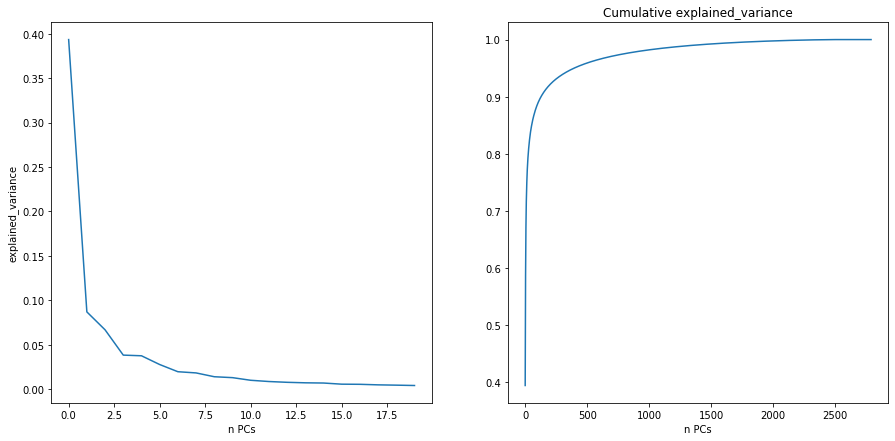

In [114]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(pesos[0:20])
plt.xlabel('n PCs')
plt.ylabel('explained_variance')
plt.subplot(1,2,2)
plt.plot(np.cumsum(pesos))
plt.xlabel('n PCs')
plt.title('Cumulative explained_variance')

In [125]:
pixeis_loading=pca.components_.T * np.sqrt(pca.explained_variance_)

#### informaçoes:
- PCA promissor, primeiro PC com 40% da informaçao do dataset e 8 PCs incluem 70%
- Avaliar hipotese de seguir com PCS vs escolher os pixeis/features mais representativos

### Criar Modelo

In [ ]:
from tensorflow.keras import models, layers
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(228 * 228,)))
network.add(layers.Dense(84, activation='softmax'))

In [ ]:
network.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
network.fit(dados, target, epochs=2, batch_size=10)

In [ ]:
features

In [ ]:
mat

In [ ]:
df = pd.DataFrame(list(mat))

In [ ]:
import pandas as pd
from scipy.io import loadmat

data_dict = loadmat('/Users/frito/Downloads/wiki_crop/wiki.mat')
data_array = data_dict['val']
data_array = data_array.transpose(1, 0)
df = pd.DataFrame(data_array,
                  columns=['ch'+str(n) for n in range(1,8)])

In [ ]:
from tensorflow.keras.datasets import mnist 

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
train_labels

In [ ]:
train_images.shape

In [ ]:
from tensorflow.keras.utils import to_categorical 
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255 
test_images = test_images.reshape((10000, 28 * 28)) 
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
test_images.shape

In [ ]:
from tensorflow.keras import models, layers
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

In [ ]:
network.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
network.fit(train_images, train_labels, epochs=10, batch_size=128)

In [ ]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

In [ ]:
im=pd.load('/Users/frito/Downloads/wiki_crop/96')

In [15]:
import os

path = '.'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))

for f in files:
    print(f[2:])

61/19242061_1982-08-16_2009.jpg
61/2399661_1977-09-02_2008.jpg
61/9494361_1962-04-21_1994.jpg
61/44438061_1937-11-14_1969.jpg
61/37699961_1890-12-11_1947.jpg
61/41899761_1989-10-06_2012.jpg
61/8794261_1970-10-06_2011.jpg
61/37117161_1956-11-28_1986.jpg
61/9707061_1986-11-12_2006.jpg
61/2265561_1987-08-25_2011.jpg
61/46518261_1922-10-16_1948.jpg
61/15330561_1943-08-11_2002.jpg
61/194961_1967-05-29_2012.jpg
61/17683961_1964-03-17_2014.jpg
61/2075561_1966-06-14_2010.jpg
61/39957661_1988-07-23_2015.jpg
61/19045461_1977-08-28_2013.jpg
61/28843761_1979-09-08_1996.jpg
61/24439461_1982-05-29_2013.jpg
61/31026761_1984-04-04_2015.jpg
61/22156261_1992-10-16_2011.jpg
61/42197061_1991-10-27_2009.jpg
61/32692161_1984-07-20_2011.jpg
61/34933261_1990-07-15_2012.jpg
61/4829861_1986-04-27_2015.jpg
61/2483261_1981-02-19_2012.jpg
61/22753061_1899-11-09_1940.jpg
61/20410261_1982-05-01_2015.jpg
61/97561_1984-10-27_2013.jpg
61/4293661_1967-05-16_1995.jpg
61/36075861_1983-09-23_2014.jpg
61/42168061_1996-06-01

59/5197959_1927-01-19_2009.jpg
59/560759_1968-07-07_2009.jpg
59/43959459_1978-06-04_2014.jpg
59/3952159_1976-05-03_2011.jpg
59/261659_1941-01-21_2008.jpg
59/314059_1961-07-19_2011.jpg
59/40640059_1887-07-04_2004.jpg
59/24924659_1951-06-02_1978.jpg
59/2057059_1907-06-05_1949.jpg
59/32985359_1955-06-07_1979.jpg
59/15045659_1974-04-09_1970.jpg
59/4518059_1978-11-02_2007.jpg
59/1777959_1929-11-14_1971.jpg
59/2237459_1980-02-07_2010.jpg
59/34803359_1981-11-22_2011.jpg
59/16154159_1952-06-22_2013.jpg
59/32275759_1984-09-03_2011.jpg
59/12207759_1987-08-07_2008.jpg
59/43721659_1974-10-16_2014.jpg
59/25501259_1991-11-07_2010.jpg
59/22986259_1986-09-26_2012.jpg
59/14067759_1932-02-20_1959.jpg
59/1004059_1964-09-19_2010.jpg
59/14468859_1930-02-28_2006.jpg
59/7875159_1975-03-20_2014.jpg
59/27261459_1978-06-15_2010.jpg
59/7922859_1954-03-04_2009.jpg
59/24872259_1949-09-30_2013.jpg
59/21621759_1984-02-13_2009.jpg
59/2498759_1975-02-11_2008.jpg
59/17504159_1946-12-21_1975.jpg
59/56359_1898-02-11_1960

66/44224166_1938-12-22_1960.jpg
66/31503866_1984-08-10_2013.jpg
66/1274866_1939-01-06_1985.jpg
66/41390466_1954-05-23_1974.jpg
66/40897566_1987-11-03_2014.jpg
66/1087766_1973-03-19_2011.jpg
66/37189666_1934-10-03_2012.jpg
66/1244066_1944-04-12_2003.jpg
66/2769066_1978-08-13_2008.jpg
66/2200266_1931-11-03_1990.jpg
66/169566_1914-05-22_1950.jpg
66/27848666_1919-12-31_2010.jpg
66/5165166_1961-12-17_2014.jpg
66/2282066_1948-03-31_2010.jpg
66/2321566_1966-03-16_2010.jpg
66/1324566_1965-09-26_2011.jpg
66/365266_1924-11-09_1958.jpg
66/518166_1951-05-01_2007.jpg
66/1175766_1888-07-04_1941.jpg
66/37275966_1966-08-21_2013.jpg
66/7209766_1980-04-30_2008.jpg
66/24729766_1962-06-01_2011.jpg
66/11699266_1983-11-30_2004.jpg
66/22343866_1967-07-10_1988.jpg
66/3629866_1985-02-09_2011.jpg
66/922666_1940-11-29_1977.jpg
66/612566_1927-01-12_1997.jpg
66/29325266_1988-01-23_2012.jpg
66/6732166_1957-10-16_1983.jpg
66/8149566_1973-01-26_2014.jpg
66/43701566_1900-07-25_2004.jpg
66/26824566_1946-10-04_2008.jpg


68/1548168_1966-12-20_2009.jpg
68/11881968_1984-12-28_2014.jpg
68/2954968_1960-06-08_2014.jpg
68/2969868_1980-03-29_2011.jpg
68/2781368_1940-03-10_1977.jpg
68/297368_1970-01-16_2009.jpg
68/16811168_1976-10-07_2012.jpg
68/9158668_1984-10-18_2011.jpg
68/23555068_1895-08-03_2005.jpg
68/2345468_1930-02-15_1986.jpg
57/4478357_1945-01-12_1972.jpg
57/641857_1929-02-14_1955.jpg
57/5785757_1981-03-08_2011.jpg
57/90757_1953-01-25_2010.jpg
57/7176557_1985-07-18_2012.jpg
57/15687557_1986-03-26_2012.jpg
57/2391057_1955-10-28_2012.jpg
57/26672957_1964-04-14_1997.jpg
57/4377557_1959-03-12_2006.jpg
57/4069657_1986-04-10_2010.jpg
57/16812357_1973-11-04_2010.jpg
57/46522857_1924-10-20_1949.jpg
57/12268357_1985-09-21_2009.jpg
57/1745457_1957-01-04_2004.jpg
57/1574157_1967-10-26_2007.jpg
57/6621157_1983-10-20_2007.jpg
57/13045657_1975-07-09_2007.jpg
57/127657_1903-09-25_1959.jpg
57/3257857_1896-04-23_1943.jpg
57/2781957_1947-12-17_2008.jpg
57/7588757_1986-03-17_2013.jpg
57/45154257_1987-08-24_2013.jpg
57/

04/11592004_1985-11-13_2009.jpg
04/8367304_1928-08-20_1947.jpg
04/30052704_1986-10-22_2010.jpg
04/23653204_1939-12-26_2015.jpg
04/8858404_1995-08-08_2012.jpg
04/5087304_1940-01-11_1999.jpg
04/20061004_1985-04-05_2008.jpg
04/1054604_1983-02-23_2014.jpg
04/7259404_1972-03-09_2012.jpg
04/42773704_1949-01-12_1985.jpg
04/2327604_1975-04-26_2008.jpg
04/2518704_1972-03-20_2006.jpg
04/486704_1952-05-11_2008.jpg
04/43908404_1921-07-08_1948.jpg
04/2564804_1951-05-06_2008.jpg
04/38507604_1986-11-02_2014.jpg
04/36216604_1997-03-20_2010.jpg
04/33415904_1940-06-24_1963.jpg
04/8029204_1965-08-27_2014.jpg
04/395604_1956-04-03_1988.jpg
04/44223904_1943-05-03_1961.jpg
04/14678904_1963-02-22_2009.jpg
04/244104_1946-04-08_2010.jpg
04/2658604_1979-04-05_2008.jpg
04/8611104_1941-08-27_2008.jpg
04/32741104_1968-04-11_1991.jpg
04/1865804_1965-08-10_2010.jpg
04/1643704_1914-12-22_1987.jpg
04/12535404_1951-06-13_2009.jpg
04/41948904_1942-09-19_1960.jpg
04/1553304_1966-09-23_1989.jpg
04/20657504_1987-04-11_2013.

35/20199935_1985-01-04_2015.jpg
35/1944935_1950-02-26_2007.jpg
35/10243035_1976-09-25_2012.jpg
35/38909235_1979-07-19_2000.jpg
35/42010035_1954-01-23_1950.jpg
35/6951435_1872-08-19_1957.jpg
35/142935_1940-09-15_2006.jpg
35/7138835_1949-12-12_2010.jpg
35/27957935_1969-09-19_2008.jpg
35/5376635_1942-05-21_2012.jpg
35/4188635_1979-05-07_2007.jpg
35/17922235_1937-03-17_1980.jpg
35/774935_1926-03-25_2004.jpg
35/28810935_1918-04-15_1967.jpg
35/4913435_1986-11-11_2014.jpg
35/1859035_1939-01-08_2007.jpg
35/1370335_1984-08-09_2010.jpg
35/9200035_1989-07-26_2009.jpg
35/509435_1980-03-18_2002.jpg
35/382535_1947-04-26_2007.jpg
35/6356035_1984-09-29_2013.jpg
35/1306335_1961-10-12_2009.jpg
35/11709935_1978-04-17_2008.jpg
35/3295235_1973-11-12_2015.jpg
35/22946135_1986-09-13_2015.jpg
35/42718835_1990-12-19_2014.jpg
35/788235_1975-05-20_2008.jpg
35/34218535_1994-01-20_2013.jpg
35/4053435_1983-06-03_2014.jpg
35/3090135_1980-09-23_2013.jpg
35/192935_1935-09-11_1962.jpg
35/26250235_1983-05-31_2010.jpg
35

51/42170551_1969-06-30_2011.jpg
51/277451_1945-01-29_2010.jpg
51/21257151_1987-05-23_2010.jpg
51/43159951_1984-12-28_2012.jpg
51/24112851_1949-05-14_2010.jpg
51/40271851_1920-07-05_1948.jpg
51/36517751_1976-09-03_2000.jpg
51/34210451_1992-04-25_2014.jpg
51/28396451_1992-01-04_2014.jpg
51/40482151_1986-09-10_1980.jpg
51/3878751_1980-01-29_2011.jpg
51/26425051_1987-02-15_2014.jpg
51/21911551_1974-04-06_2011.jpg
51/48351_1888-05-11_1941.jpg
51/9188951_1984-02-25_2011.jpg
51/18249151_1970-12-16_2004.jpg
51/6591251_1927-09-17_2012.jpg
51/166651_1949-08-23_2004.jpg
51/14689551_1950-01-19_2008.jpg
51/2543851_1928-11-20_2006.jpg
51/6024651_1988-01-17_2011.jpg
51/36477551_1981-11-02_2012.jpg
51/16228051_1966-10-22_1960.jpg
51/4155251_1977-12-22_2012.jpg
51/223251_1924-09-20_1951.jpg
51/42635551_1949-11-01_2013.jpg
51/4200351_1980-01-02_2002.jpg
51/19554151_1986-04-09_2014.jpg
51/24871451_1941-04-03_1966.jpg
51/1039151_1946-07-02_2014.jpg
51/33880651_1982-01-01_2011.jpg
51/8118051_1941-05-01_196

67/5898167_1927-05-23_2011.jpg
67/11652167_1985-01-08_2009.jpg
67/45274267_2002-04-12_2002.jpg
67/23715067_1983-11-06_2007.jpg
67/41232167_1994-11-28_2012.jpg
67/38791867_1935-04-06_2012.jpg
67/43176367_1983-01-08_2012.jpg
67/40041267_1990-12-13_2013.jpg
67/4015767_1958-07-12_2008.jpg
67/38510967_1990-07-12_2012.jpg
67/2056167_1952-07-03_1970.jpg
67/42872867_1918-05-03_1943.jpg
67/1716867_1932-06-20_2012.jpg
67/567167_1959-06-27_1993.jpg
67/594667_1963-05-11_1999.jpg
67/31555967_1985-09-14_2013.jpg
67/46416967_1955-10-02_1979.jpg
67/34528567_1952-01-15_2005.jpg
67/36335767_1987-02-25_2012.jpg
67/431867_1915-04-26_1991.jpg
67/32751767_1975-08-15_1997.jpg
67/36231467_1944-01-24_1964.jpg
67/5138967_1932-02-29_2007.jpg
67/2636467_1979-05-24_2001.jpg
67/27821767_1988-11-14_2014.jpg
67/11060967_1974-06-06_2012.jpg
67/3126767_1989-12-04_2014.jpg
67/7419967_1935-01-03_1966.jpg
67/29592067_1991-09-22_2010.jpg
67/45967_1925-11-10_1953.jpg
67/3587667_1973-12-26_2006.jpg
67/315567_1973-02-12_2012.

94/41972394_1992-01-30_2014.jpg
94/30107294_1986-02-26_2012.jpg
94/14465194_1938-11-23_2010.jpg
94/54594_1954-10-09_2011.jpg
94/46517894_1928-02-19_1950.jpg
94/9116794_1977-10-24_2013.jpg
94/27054194_1882-04-21_2004.jpg
94/42515594_1959-01-17_2010.jpg
94/2223094_1965-04-30_2008.jpg
94/17936494_1986-12-11_2010.jpg
94/4371894_1982-03-30_2005.jpg
94/3873394_1946-08-05_1974.jpg
94/13060494_1967-02-23_2007.jpg
94/1616894_1979-07-26_2007.jpg
94/341294_1974-02-22_2009.jpg
94/34292794_1992-12-02_2012.jpg
94/5238794_1944-04-16_2009.jpg
94/905394_1948-03-24_1980.jpg
60/24796560_1968-01-08_2009.jpg
60/38233160_1919-12-15_1942.jpg
60/27574460_1977-04-29_2015.jpg
60/4238260_1975-02-26_2012.jpg
60/340560_1947-08-24_1989.jpg
60/44439860_1930-01-30_1955.jpg
60/13443660_1987-03-13_2011.jpg
60/12869260_1987-08-11_2013.jpg
60/36133060_1916-07-18_2012.jpg
60/25960660_1879-04-23_1944.jpg
60/1249260_1917-10-13_1954.jpg
60/4181260_1945-02-20_1972.jpg
60/44243660_1931-10-15_1956.jpg
60/12074560_1969-02-28_200

33/288033_1958-01-24_2009.jpg
33/2669233_1946-12-24_2010.jpg
33/7034933_1978-10-20_2006.jpg
33/38340333_1990-10-15_2014.jpg
33/22291933_1957-11-12_1981.jpg
33/444933_1975-01-25_2012.jpg
33/37022033_1979-08-21_1998.jpg
33/1498233_1949-08-26_2009.jpg
33/50133_1938-03-14_1968.jpg
33/369433_1952-07-10_2002.jpg
33/21178733_1988-06-14_2007.jpg
33/8469933_1982-07-06_2009.jpg
33/21908633_1986-04-20_2014.jpg
33/43519133_1989-02-05_2012.jpg
33/34553233_1981-08-28_2007.jpg
33/600233_1961-06-27_2013.jpg
33/29945333_1990-06-05_2012.jpg
33/3506433_1952-10-07_1977.jpg
33/1872933_1993-06-09_2008.jpg
33/37984833_1993-05-30_2015.jpg
33/419633_1951-04-06_2008.jpg
33/12606833_1988-05-26_2015.jpg
33/43142133_1946-03-11_1998.jpg
33/252633_1962-12-08_2015.jpg
33/43316533_1982-12-10_2014.jpg
33/261933_1943-07-05_2007.jpg
33/1077133_1882-11-14_1974.jpg
33/31210533_1624-05-23_2011.jpg
33/37097733_1991-12-10_2012.jpg
33/33066633_1986-01-16_2014.jpg
33/33300733_1987-10-01_2012.jpg
33/38547133_1967-11-01_2009.jpg


02/13821502_1987-11-14_2008.jpg
02/36605802_1979-01-16_2012.jpg
02/11221502_1987-02-02_2011.jpg
02/20023502_1933-07-28_1953.jpg
02/4945702_1984-07-03_2010.jpg
02/46229502_1986-03-20_2015.jpg
02/38264002_1919-01-10_1960.jpg
02/22468002_1991-09-23_2014.jpg
02/999202_1978-09-15_2006.jpg
02/1298502_1967-03-01_2013.jpg
02/663102_1959-12-08_2014.jpg
02/28033802_1985-11-23_2014.jpg
02/3663402_1961-02-22_2013.jpg
02/3093802_1980-02-19_2007.jpg
02/1650702_1869-11-21_2005.jpg
02/38076302_1929-03-20_1959.jpg
02/13687702_1947-01-05_2011.jpg
02/29764702_1991-03-05_2014.jpg
02/36200202_1978-05-03_1970.jpg
02/2726002_1974-04-26_2014.jpg
02/16973102_1952-12-21_1981.jpg
02/3083902_1939-01-03_1979.jpg
02/3323202_1976-05-06_2009.jpg
02/645102_1925-09-01_1979.jpg
02/42120902_1997-09-18_2013.jpg
02/17690502_1957-10-29_2010.jpg
02/72202_1921-05-23_2007.jpg
02/15874302_1907-05-29_1942.jpg
02/344402_1971-07-22_2010.jpg
02/25072702_1983-02-15_2014.jpg
02/31084902_1968-11-05_2009.jpg
02/41144802_1950-05-04_1977

18/18048418_1971-06-19_2008.jpg
18/40167818_1892-04-03_1949.jpg
18/1775018_1979-03-26_2009.jpg
18/40818918_1890-09-06_1943.jpg
18/9608918_1958-09-22_2012.jpg
18/16680218_1981-05-29_2011.jpg
18/42867918_1969-09-13_2014.jpg
18/24527018_1962-03-24_2009.jpg
18/21865418_1977-05-26_2014.jpg
18/31431018_1924-02-07_1965.jpg
18/2606118_1967-12-05_2014.jpg
18/8783818_1909-01-05_1985.jpg
18/423018_1947-08-27_1974.jpg
18/8348018_1906-01-22_1948.jpg
27/46498327_1934-12-25_1958.jpg
27/46725727_1925-06-03_1951.jpg
27/19690827_1982-03-19_2012.jpg
27/24249227_1988-10-31_2010.jpg
27/7829427_1983-03-31_2007.jpg
27/4958927_1984-03-19_2011.jpg
27/1231727_1928-12-09_2010.jpg
27/35963627_1986-01-19_2014.jpg
27/28330927_1974-06-25_1997.jpg
27/4037327_1984-04-12_2013.jpg
27/31233727_1959-01-22_2011.jpg
27/4948727_1983-04-30_2013.jpg
27/6923827_1981-08-15_2014.jpg
27/3147127_1981-05-19_2009.jpg
27/24285327_1993-05-07_2013.jpg
27/41396027_1961-07-27_1989.jpg
27/41501227_1992-02-05_2013.jpg
27/28924827_1924-09-18

29/36348129_1987-06-01_2012.jpg
29/46673029_1950-12-04_1970.jpg
29/39097029_1981-02-23_2011.jpg
29/1748529_1941-05-06_1999.jpg
29/36573729_1987-08-11_2012.jpg
29/25053529_1974-09-26_2011.jpg
29/2331929_1978-12-30_2011.jpg
29/9545829_1977-11-05_2009.jpg
29/2852129_1986-11-12_2007.jpg
29/12607029_1979-05-15_2011.jpg
29/33851629_1985-03-19_2011.jpg
29/46726029_1917-01-10_1942.jpg
29/31639629_1988-12-17_2012.jpg
29/845829_1946-10-31_2005.jpg
29/6076929_1977-03-28_1970.jpg
29/23108329_1991-06-20_2013.jpg
29/8298229_1920-04-30_1984.jpg
29/157729_1934-01-14_2009.jpg
29/8177329_1967-08-17_2015.jpg
29/19045529_1961-08-24_2008.jpg
29/20459229_1973-05-11_2011.jpg
29/46683029_1943-12-05_1963.jpg
29/346029_1974-02-07_2013.jpg
29/2384229_1935-07-20_1998.jpg
29/45026529_1934-05-06_1958.jpg
29/157429_1960-09-29_2009.jpg
29/41714229_1907-09-03_1941.jpg
29/4641629_1980-01-08_2014.jpg
29/22605229_1982-07-28_2009.jpg
29/25737929_1976-08-01_2011.jpg
29/6517629_1982-10-20_2009.jpg
29/3253729_1981-04-05_2013

42/33520342_1912-10-27_1979.jpg
42/3187142_1976-07-10_2009.jpg
42/1895242_1945-01-11_2002.jpg
42/7512942_1975-02-26_2004.jpg
42/1890442_1975-03-29_2010.jpg
42/873842_1947-09-13_2007.jpg
42/29056942_1987-02-05_2012.jpg
42/2590542_1984-03-11_2007.jpg
42/33441542_1945-01-02_2010.jpg
42/3853642_1982-09-14_2008.jpg
42/35869542_1980-10-03_2012.jpg
42/22476142_1949-09-13_2013.jpg
42/161742_1916-12-13_1975.jpg
42/32687542_1927-02-16_2008.jpg
42/37591142_1990-11-10_2013.jpg
42/33415942_1937-03-20_1963.jpg
42/36701642_1985-11-21_2009.jpg
42/18977742_1988-10-13_2015.jpg
42/36225742_1928-04-13_2010.jpg
42/4087942_1890-03-26_1943.jpg
42/10957242_1985-10-02_2012.jpg
42/2565242_1991-06-18_2015.jpg
42/22156642_1927-06-04_1974.jpg
42/37702542_1988-04-10_2015.jpg
42/42170642_1892-05-23_1968.jpg
42/40598642_1992-05-07_2014.jpg
42/84242_1970-12-14_2009.jpg
42/40045942_1993-04-20_2012.jpg
42/34983242_1989-04-26_2012.jpg
42/34118242_1986-07-26_2009.jpg
42/7399042_1930-01-02_1952.jpg
42/1101442_1943-06-01_19

73/1712473_1942-05-23_1970.jpg
73/35173873_1956-02-20_2007.jpg
73/34954873_1984-05-12_2011.jpg
73/40805073_1993-07-06_2012.jpg
73/25909573_1932-05-16_1951.jpg
73/29904573_1957-06-30_1983.jpg
73/39467373_1976-08-27_2007.jpg
73/305473_1975-06-07_2008.jpg
73/27122073_1987-09-07_2010.jpg
73/2447573_1957-08-15_2007.jpg
73/505973_1951-04-22_2009.jpg
73/4654273_1973-11-13_1993.jpg
73/2430073_1974-11-09_2013.jpg
73/1530473_1939-04-09_1972.jpg
73/162473_1939-02-26_2012.jpg
73/44456073_1954-11-21_2011.jpg
73/44091973_1987-01-18_2015.jpg
73/1219773_1954-11-14_1982.jpg
73/3081573_1953-09-16_1978.jpg
73/10502473_1930-05-06_1952.jpg
73/43198473_1988-09-26_2014.jpg
73/24405773_1991-08-07_2012.jpg
73/327073_1948-06-21_2011.jpg
73/46813973_1947-05-08_2010.jpg
73/17086273_1950-04-06_2005.jpg
73/30640573_1958-04-03_2010.jpg
73/20985073_1984-07-07_2010.jpg
73/47043973_1925-08-16_1977.jpg
73/475973_1958-02-20_2011.jpg
73/20845373_1978-08-28_2008.jpg
73/38773_1905-12-05_1976.jpg
73/26095273_1987-08-24_2010.

74/8492174_1988-05-25_2007.jpg
74/35109974_1994-06-01_2012.jpg
74/320774_1927-01-10_1969.jpg
74/2588374_1957-07-13_2010.jpg
74/10509874_1959-11-28_2012.jpg
74/21113974_1934-02-12_1979.jpg
74/8957974_1908-07-28_1946.jpg
74/3075674_1924-05-18_1968.jpg
74/1299774_1979-06-02_2009.jpg
74/2225774_1970-03-08_2012.jpg
74/33310774_1977-02-22_2012.jpg
74/19165474_1963-04-08_2013.jpg
74/9384974_1927-03-14_1983.jpg
74/37002774_1990-06-23_2014.jpg
74/4528174_1942-01-03_2010.jpg
74/1345074_1923-12-25_2007.jpg
74/2422774_1978-09-17_2014.jpg
74/13741274_1951-01-05_1981.jpg
74/31511074_1953-11-27_2011.jpg
74/29074_1920-02-25_2010.jpg
74/1537974_1941-11-07_2014.jpg
74/11016074_1963-08-07_1986.jpg
74/8638874_1965-06-21_2013.jpg
74/27048574_1979-01-16_2008.jpg
74/951674_1963-03-14_1988.jpg
74/43310074_1998-07-15_2014.jpg
74/3777174_1946-08-27_2015.jpg
74/3216774_1942-02-01_1964.jpg
74/2512874_1933-07-31_2011.jpg
74/23315074_1980-12-31_2013.jpg
74/14948174_1931-08-01_1965.jpg
74/28618474_1973-10-18_2000.jp

10/43675010_1981-07-26_2010.jpg
10/36703410_1982-06-24_2011.jpg
10/17208410_1928-03-21_1964.jpg
10/21197710_1991-01-02_2009.jpg
10/12398210_1965-01-24_2010.jpg
10/44223010_1946-06-15_1969.jpg
10/643710_1958-09-25_2015.jpg
10/28926910_1993-03-23_2013.jpg
10/12939010_1979-02-01_2013.jpg
10/433710_1941-05-19_1998.jpg
10/31853710_1976-09-30_2010.jpg
10/4389210_1899-12-13_1952.jpg
10/6631910_1984-08-27_1988.jpg
10/2292110_1963-08-18_2013.jpg
10/2617810_1963-06-27_1998.jpg
10/26681910_1988-11-23_2015.jpg
10/1123810_1978-05-15_2011.jpg
10/44530710_1996-02-02_2015.jpg
10/31573810_1941-01-26_1967.jpg
10/1093210_1934-03-22_1960.jpg
10/3213810_1968-11-11_1996.jpg
10/3416810_1972-12-17_2006.jpg
10/42520610_1985-06-11_1981.jpg
10/46794610_1934-03-14_1957.jpg
10/22715310_1946-05-10_1970.jpg
10/214210_1970-01-11_2010.jpg
10/32297410_1991-12-30_2011.jpg
10/41942010_1963-03-31_2012.jpg
10/46524310_1922-06-18_1946.jpg
10/26893910_1933-02-05_1967.jpg
10/8088410_1958-12-16_1983.jpg
10/9372610_1982-03-26_2

21/332221_1903-07-21_2007.jpg
21/40783721_1958-04-16_2013.jpg
21/15872621_1922-08-28_1952.jpg
21/5277721_1987-03-20_2010.jpg
21/2797621_1960-03-15_2011.jpg
21/12261121_1985-01-04_2014.jpg
21/43345421_1999-10-22_2014.jpg
21/250721_1956-06-03_2010.jpg
21/21609821_1907-03-04_1983.jpg
21/9404921_1978-07-09_2009.jpg
21/46982821_1994-06-09_2015.jpg
21/16521_1938-12-29_2011.jpg
21/9035121_1967-10-27_2011.jpg
21/2108221_1961-06-24_2008.jpg
21/174821_1961-09-25_1993.jpg
21/295321_1904-08-23_1955.jpg
21/8774721_1967-04-29_2010.jpg
21/7170221_1933-03-27_1983.jpg
21/551221_1928-02-22_2007.jpg
21/101721_1971-07-21_2011.jpg
21/20599521_1967-08-09_2012.jpg
21/567621_1982-11-02_2007.jpg
21/23741921_1965-12-17_2010.jpg
21/10172021_1963-06-02_2006.jpg
21/3555521_1975-08-20_2006.jpg
21/7623721_1978-03-01_2010.jpg
21/12401321_1954-01-23_1974.jpg
21/21506721_1985-10-16_2011.jpg
21/1825621_1945-09-08_2008.jpg
21/24644621_1964-12-15_2010.jpg
21/4137921_1965-08-22_2013.jpg
21/5595421_1983-02-04_2015.jpg
21/91

86/205086_1965-01-20_2008.jpg
86/21222086_1978-04-04_2006.jpg
86/12930586_1983-05-24_2008.jpg
86/908286_1934-07-04_1990.jpg
86/20281686_1964-12-10_2008.jpg
86/36589086_1996-04-21_2012.jpg
86/19631386_1941-04-05_2012.jpg
86/23536186_1895-10-25_1968.jpg
86/7159286_1987-04-25_2004.jpg
86/19029186_1979-07-19_2009.jpg
86/866486_1959-02-02_2010.jpg
86/7955886_1991-03-08_2010.jpg
86/36076086_1975-07-13_2006.jpg
86/998786_1957-01-17_2015.jpg
86/1653786_1998-04-09_2014.jpg
86/789386_1976-07-27_2007.jpg
86/585086_1926-04-22_1988.jpg
86/193486_1939-05-28_2006.jpg
86/18666186_1984-11-07_2015.jpg
86/7623086_1978-09-12_2009.jpg
86/217686_1969-01-02_2011.jpg
86/28649186_1985-05-18_2011.jpg
86/5268986_1940-07-03_1973.jpg
86/22450586_1952-01-11_1979.jpg
86/4932786_1977-12-22_2008.jpg
86/13026586_1975-10-25_1996.jpg
86/44090786_1929-03-23_1951.jpg
86/3629786_1978-03-18_2008.jpg
86/13284886_1984-11-14_2012.jpg
86/2348186_1979-04-21_2003.jpg
86/8925686_1928-10-10_2007.jpg
86/36874886_1977-07-12_2014.jpg
8

43/32794243_1969-01-25_2011.jpg
43/39822743_1984-06-22_2006.jpg
43/559443_1969-10-15_2007.jpg
43/21238943_1991-06-07_2015.jpg
43/10170443_1923-04-15_1951.jpg
43/12614543_1976-03-18_2007.jpg
43/3866243_1986-11-15_2013.jpg
43/38843_1976-10-08_2007.jpg
43/7025943_1930-09-09_2002.jpg
43/31839543_1952-12-15_2011.jpg
43/430543_1944-07-17_2008.jpg
43/31915743_1979-04-07_2008.jpg
43/3555143_1958-06-22_2012.jpg
43/1147343_1945-05-31_2011.jpg
43/23339143_1945-12-08_1940.jpg
43/35230443_1961-08-05_2011.jpg
43/948843_1970-06-28_2011.jpg
43/22713343_1929-05-11_1984.jpg
43/893143_1975-07-25_2008.jpg
43/19352343_1981-10-24_2013.jpg
43/18715443_1930-10-03_1970.jpg
43/27411343_1986-03-12_2014.jpg
43/37022743_1969-09-29_1996.jpg
43/14944543_1936-03-06_2008.jpg
43/15306243_1963-12-22_2007.jpg
43/67943_1922-01-21_1974.jpg
43/22332643_1936-10-09_1962.jpg
43/6733343_1975-09-16_2008.jpg
43/22473543_1953-01-09_1979.jpg
43/19376643_1948-06-19_1973.jpg
43/592843_1898-07-04_1947.jpg
43/1003243_1965-04-10_2007.jp

38/30175038_1986-10-26_2013.jpg
38/4649538_1960-03-28_1985.jpg
38/1270638_1933-10-27_2012.jpg
38/46370838_1979-10-15_2010.jpg
38/12283138_1960-07-09_2010.jpg
38/862138_1966-04-09_2007.jpg
38/1686138_1978-10-03_2011.jpg
38/10697838_1968-09-17_2014.jpg
38/14174838_1955-11-13_2007.jpg
38/39051038_1964-04-28_2013.jpg
38/45403138_1920-07-31_1947.jpg
38/2022138_1961-04-21_2013.jpg
38/4287138_1936-01-21_2006.jpg
38/1507538_1939-11-07_2010.jpg
38/8015338_1981-04-18_2010.jpg
38/18045138_1975-10-19_2006.jpg
38/13827238_1986-01-20_2010.jpg
38/524938_1957-01-17_2013.jpg
38/39339138_1991-05-06_2013.jpg
38/5781838_1975-03-05_2003.jpg
38/5178238_1951-05-27_2006.jpg
38/5845638_1984-05-23_2015.jpg
38/20768838_1977-05-28_2009.jpg
38/1962338_1973-04-24_2012.jpg
38/22192238_1937-03-13_1974.jpg
38/37738938_2005-10-17_2012.jpg
38/46726038_1920-07-04_1945.jpg
38/38475038_1988-01-23_2011.jpg
38/2984238_1971-01-26_2006.jpg
38/7367638_1957-10-27_2011.jpg
38/35072838_1990-01-29_2011.jpg
38/5186938_1957-08-02_199

09/19786909_1983-04-12_2012.jpg
09/1251109_1939-10-10_2013.jpg
09/5522509_1978-03-14_2014.jpg
09/24387909_1952-12-31_2010.jpg
09/39638309_1986-06-18_2015.jpg
09/12008109_1986-11-01_2009.jpg
09/30631709_1928-07-30_2009.jpg
09/38814309_1991-08-30_2013.jpg
09/5870209_1948-03-22_1973.jpg
09/41404509_1942-07-15_1968.jpg
09/2055209_1958-09-27_2012.jpg
09/652909_1948-03-15_2010.jpg
09/44946809_1925-04-11_1952.jpg
09/1819809_1895-09-07_1945.jpg
09/23394009_1953-04-16_2009.jpg
09/28322509_1989-09-04_2010.jpg
09/1016409_1981-02-25_2014.jpg
09/43966209_1991-03-28_2014.jpg
09/31960909_1952-12-31_2011.jpg
09/6255309_1952-08-20_2005.jpg
09/21501309_1899-03-14_1950.jpg
09/46449009_1946-04-27_1967.jpg
09/35660209_1993-02-13_2013.jpg
09/11192209_1979-03-12_2006.jpg
09/17259709_1927-12-02_1951.jpg
09/42263309_1926-10-04_1983.jpg
09/23956309_1989-10-20_2012.jpg
09/25646509_1964-10-17_2011.jpg
09/301009_1953-12-29_2000.jpg
09/46906209_1994-12-10_2015.jpg
09/38310109_1990-05-03_2013.jpg
09/376009_1962-07-1

65/35470065_1993-02-24_2010.jpg
65/46429665_1972-11-28_2014.jpg
65/9952265_1951-10-08_2011.jpg
65/1857165_1962-03-06_2009.jpg
65/29113365_1989-05-11_2013.jpg
65/41853165_1983-02-01_2009.jpg
65/18224865_1989-03-28_2007.jpg
65/2420165_1946-03-19_2005.jpg
65/2198265_1940-01-05_1965.jpg
65/14572865_1964-04-10_1960.jpg
65/3627165_1972-12-14_2003.jpg
65/2031465_1886-11-24_1951.jpg
65/32531665_1992-11-10_2010.jpg
65/4250465_1974-11-10_2013.jpg
65/27489165_1989-09-16_2015.jpg
65/1221065_1959-10-03_2008.jpg
65/9921965_1939-12-08_1974.jpg
65/12379565_1925-01-25_1964.jpg
65/952865_1963-04-11_2007.jpg
65/5738165_1960-03-10_2015.jpg
65/2437065_1984-05-11_2012.jpg
65/15609065_1981-09-27_2010.jpg
65/3058665_1924-10-14_1966.jpg
65/41207465_1921-03-02_1945.jpg
65/10001965_1930-05-23_1961.jpg
65/43257765_1941-07-03_2013.jpg
65/10112565_1969-02-08_1960.jpg
65/884465_1955-10-02_2014.jpg
65/14209065_1949-09-29_2008.jpg
65/3954265_1924-05-30_1999.jpg
65/11043165_1981-03-01_2013.jpg
65/17109065_1985-06-14_20

96/15669496_1987-02-11_2014.jpg
96/22421796_1955-06-25_1983.jpg
96/5028096_1938-11-11_1964.jpg
96/4589996_1964-09-24_1987.jpg
96/21873796_1965-07-02_2007.jpg
96/5042896_1958-12-24_1986.jpg
96/8769096_1973-12-01_2013.jpg
96/10648596_1962-08-25_2010.jpg
96/8177396_1983-10-17_2006.jpg
96/5897896_1936-12-03_1990.jpg
96/1993996_1975-01-31_2012.jpg
96/3674396_1941-01-24_2011.jpg
96/3616196_1960-08-23_2005.jpg
96/25296596_1952-11-30_2000.jpg
96/29095196_1945-06-15_2009.jpg
96/36668696_1992-08-17_2012.jpg
96/44224296_1935-07-15_1958.jpg
96/40649796_1979-06-17_2012.jpg
96/29200196_1970-01-01_2014.jpg
96/13485596_1984-05-14_2011.jpg
96/46794596_1937-01-09_1957.jpg
96/4673596_1936-07-01_1959.jpg
96/12931396_1938-09-06_2008.jpg
96/40877496_1993-02-14_2013.jpg
96/43159496_1954-01-22_1976.jpg
96/31799796_1980-04-24_2009.jpg
96/2604896_1987-10-24_2007.jpg
96/29869796_1986-03-09_2013.jpg
96/4181396_1946-12-16_2009.jpg
96/215196_1934-02-11_1964.jpg
96/42472796_1953-08-27_2011.jpg
96/19544096_1981-07-04

30/30231130_1957-12-26_2011.jpg
30/1978830_1962-11-16_2014.jpg
30/12049130_1901-11-15_1941.jpg
30/34730730_1978-03-24_2012.jpg
30/1550330_1902-04-05_1946.jpg
30/245430_1906-11-07_1961.jpg
30/6731130_1927-04-29_1950.jpg
30/2800730_1936-03-21_2008.jpg
30/950330_1959-11-06_2006.jpg
30/24440830_1956-10-21_2012.jpg
30/43331030_1992-09-02_2012.jpg
30/2633030_1934-11-14_2006.jpg
30/4210630_1953-10-23_2011.jpg
30/219130_1955-02-19_2011.jpg
30/1925130_1963-02-06_2005.jpg
30/33931330_1993-05-31_2015.jpg
30/6849030_1908-10-06_1947.jpg
30/24972730_2000-04-09_2013.jpg
30/15830_1917-08-22_1997.jpg
30/22758130_1986-04-18_2011.jpg
30/28452930_1991-06-20_2014.jpg
30/469430_1934-02-25_1955.jpg
30/3206330_1980-11-16_2007.jpg
30/44243530_1927-06-29_1952.jpg
30/39369330_1984-01-09_2008.jpg
30/20988530_1973-04-20_2011.jpg
30/978030_1925-03-14_1961.jpg
30/9391630_1940-04-27_1964.jpg
30/8595330_1953-09-30_2001.jpg
30/292930_1959-08-27_2005.jpg
30/2293230_1984-03-08_2009.jpg
30/6477830_1958-10-06_2007.jpg
30/1

08/3669208_1976-02-11_2012.jpg
08/25679508_1993-06-08_2013.jpg
08/5603208_1986-03-30_2013.jpg
08/22116708_1893-02-07_2004.jpg
08/4574608_1924-05-18_1952.jpg
08/39932208_1957-06-02_2013.jpg
08/4408_1936-09-07_1957.jpg
08/2601208_1957-05-17_2003.jpg
08/39567408_1961-09-19_2014.jpg
08/1824908_1954-02-13_2011.jpg
08/37619508_1973-09-07_2014.jpg
08/7990008_1931-06-01_1959.jpg
08/40433608_1992-08-23_2015.jpg
08/5017808_1980-05-04_2013.jpg
08/22380408_1951-07-06_1974.jpg
08/20715808_1948-02-26_2010.jpg
08/2294508_1978-09-13_1974.jpg
08/15089808_1909-01-06_1953.jpg
08/4278308_1947-01-11_1968.jpg
08/20339108_1932-01-13_2011.jpg
08/14272108_1946-07-11_1995.jpg
08/27661408_1987-03-20_2012.jpg
08/266108_1960-02-23_2015.jpg
08/2190408_1984-08-11_2013.jpg
08/10714208_1912-11-25_1942.jpg
08/20935708_1991-03-02_2008.jpg
08/42061008_1921-12-01_1959.jpg
08/3656008_1957-04-06_1980.jpg
08/7199108_1983-12-14_2012.jpg
08/30284508_1961-01-22_2007.jpg
08/786408_1924-07-06_1952.jpg
08/13149808_1987-06-13_2014.

39/33133639_1989-08-13_2004.jpg
39/4610939_1982-06-25_2010.jpg
39/38226639_1992-01-17_2010.jpg
39/21296239_1982-11-14_2012.jpg
39/1469739_1961-10-23_1996.jpg
39/15238839_1971-03-14_2011.jpg
39/5372439_1967-02-17_2011.jpg
39/26873539_1906-08-22_2004.jpg
39/6145339_1884-05-30_1942.jpg
39/6659539_1946-08-25_2007.jpg
39/14256239_1975-04-24_1970.jpg
39/736739_1921-03-22_1969.jpg
39/37605039_1933-06-12_1962.jpg
39/20016339_1992-02-09_2009.jpg
39/24657439_1967-12-13_2013.jpg
39/2440939_1973-04-17_2007.jpg
39/3530539_1957-06-19_2011.jpg
39/16909739_1985-04-05_2007.jpg
39/28673439_1976-06-26_1997.jpg
39/377839_1964-04-12_2008.jpg
39/19140739_1983-02-06_2008.jpg
39/41147439_1956-08-15_1980.jpg
39/14431439_1941-06-23_1970.jpg
39/36763639_1970-10-06_2011.jpg
39/1162139_1938-05-19_2009.jpg
39/31959639_1986-09-27_2010.jpg
39/25167039_1920-07-10_1948.jpg
39/14825439_1948-03-31_2006.jpg
39/36795539_1947-06-14_2009.jpg
39/3882139_1947-05-23_1980.jpg
39/41171739_1987-08-10_2007.jpg
39/32321839_1906-02-0

55/27499555_1957-06-17_2008.jpg
55/17179755_1981-09-16_2004.jpg
55/4671755_1965-05-06_1989.jpg
55/32863655_1904-07-05_1947.jpg
55/19029755_1990-06-16_2015.jpg
55/21379355_1989-12-30_2009.jpg
55/37821455_1927-04-19_1962.jpg
55/44013455_1974-10-01_2013.jpg
55/43478755_1976-08-19_2013.jpg
55/42488955_1987-09-30_2014.jpg
55/1329655_1962-05-15_2008.jpg
55/3324955_1967-10-02_2010.jpg
55/30076355_1992-09-21_2012.jpg
55/2369955_1890-07-11_1945.jpg
55/35278855_1911-08-18_1957.jpg
55/9835555_1973-04-10_2004.jpg
55/43910955_1920-02-08_1948.jpg
55/46862055_1933-01-28_2011.jpg
55/23461755_1943-12-30_1965.jpg
55/7900755_1986-11-20_2011.jpg
55/44117855_1922-11-30_1947.jpg
55/1074155_1966-02-28_2014.jpg
55/1449555_1985-12-23_2007.jpg
55/2207955_1976-08-26_2008.jpg
55/1882755_1985-12-19_2009.jpg
55/6949055_1985-11-17_2009.jpg
55/36604455_1977-04-14_1999.jpg
55/650755_1969-12-05_2013.jpg
55/14232455_1900-03-16_1956.jpg
55/33588655_1989-03-19_2007.jpg
55/4639455_1979-05-17_2008.jpg
55/2807755_1978-07-04_

64/15307164_1984-08-20_2011.jpg
64/11644064_1952-08-09_1990.jpg
64/4233664_1935-03-30_1962.jpg
64/3083564_1980-11-12_2011.jpg
64/30632364_1990-03-08_2013.jpg
64/10276064_1955-11-27_2007.jpg
64/12964_1953-07-29_2008.jpg
64/27846664_1901-11-01_2010.jpg
64/13613264_1972-05-09_2010.jpg
64/41345364_1960-07-07_1992.jpg
64/12620064_1989-11-30_2010.jpg
64/36292264_1877-06-23_1961.jpg
64/26264_1947-03-06_2008.jpg
64/644264_1973-02-24_2011.jpg
64/4531664_1967-09-14_2005.jpg
64/42015364_1987-06-14_2013.jpg
64/468364_1959-12-29_2011.jpg
64/23863464_1987-04-16_2011.jpg
64/149564_1948-10-09_1980.jpg
64/847764_1914-01-13_1954.jpg
64/1528264_1976-03-17_2007.jpg
64/18843264_1984-06-23_2011.jpg
64/43164064_1995-07-28_2015.jpg
64/40693164_1990-12-05_2014.jpg
64/230664_1927-07-06_1953.jpg
64/3484664_1983-08-18_2008.jpg
64/5432064_1971-07-30_2006.jpg
64/33188864_1975-06-16_2011.jpg
64/42334164_1908-05-27_2014.jpg
64/46417864_1953-05-25_1973.jpg
64/7284964_1929-07-23_1976.jpg
64/4467364_1972-03-06_2009.jpg


46/273446_1910-02-04_1969.jpg
46/4759146_1951-12-12_1983.jpg
46/1438046_1976-12-07_2007.jpg
46/2555546_1988-01-13_2011.jpg
46/42548146_1990-01-19_2014.jpg
46/36275746_1985-08-30_2012.jpg
46/4037946_1982-11-18_2010.jpg
46/41217746_1966-12-09_1986.jpg
46/20912846_1964-05-12_2008.jpg
46/40490446_1990-07-31_2015.jpg
46/34711046_1997-09-06_2012.jpg
46/8445546_1988-03-25_2008.jpg
46/9890546_1978-11-17_2004.jpg
46/2628646_1978-04-08_2014.jpg
46/618546_1954-03-16_2012.jpg
46/9751046_1958-06-24_2010.jpg
46/44835846_1946-12-08_1978.jpg
46/348946_1889-04-18_1970.jpg
46/14894146_1976-04-08_2009.jpg
46/2411046_1913-11-05_1992.jpg
46/576546_1937-07-04_2004.jpg
46/5379646_1917-11-13_1956.jpg
46/37525846_1988-03-25_2013.jpg
79/24252679_1986-02-26_2013.jpg
79/6209679_1948-05-13_2003.jpg
79/63179_1921-01-05_1989.jpg
79/2447379_1979-12-12_2009.jpg
79/42347079_1969-06-11_2014.jpg
79/8947279_1815-02-05_2006.jpg
79/18527279_1992-02-23_2015.jpg
79/25192779_1976-02-03_2008.jpg
79/40240679_1901-10-21_1942.jpg


83/25194683_1964-07-31_1985.jpg
83/20634583_1985-07-27_2014.jpg
83/16477183_1978-09-05_1970.jpg
83/13686383_1947-04-20_1940.jpg
83/3160583_1970-01-31_2011.jpg
83/41395883_1948-12-27_1972.jpg
83/27083483_1987-03-17_2014.jpg
83/615883_1976-09-27_2014.jpg
83/42083_1901-02-01_1940.jpg
83/2022883_1981-07-21_2010.jpg
83/757483_1971-03-13_2007.jpg
83/37392283_1993-06-06_2012.jpg
83/15921683_1939-11-24_1964.jpg
83/2879783_1957-02-03_2008.jpg
83/26334683_1947-03-02_1976.jpg
83/30101583_1976-12-29_2001.jpg
83/18725383_1999-05-28_2011.jpg
83/33513783_1985-11-24_2010.jpg
83/31227083_1937-08-02_1970.jpg
83/41450283_1993-04-04_2013.jpg
83/2889083_1956-08-26_2007.jpg
83/14521583_1926-06-14_1948.jpg
83/3527983_1985-09-07_2005.jpg
83/34785183_1975-04-11_2004.jpg
83/5294583_1953-03-31_2012.jpg
83/7160083_1971-09-01_2012.jpg
83/3644383_1975-02-19_2006.jpg
83/767983_1962-11-09_2003.jpg
83/35102183_1973-06-30_2011.jpg
83/5572583_1933-06-14_1962.jpg
83/2299983_1937-11-17_1964.jpg
83/12787083_1983-04-11_2009

70/13052970_1973-09-23_2013.jpg
70/14538770_1981-01-22_2004.jpg
70/21639770_1985-03-02_2011.jpg
70/16782670_1985-01-02_2009.jpg
70/1441870_1966-02-13_2006.jpg
70/405770_1944-09-24_1996.jpg
70/436870_1945-11-05_2006.jpg
70/19049170_1989-06-14_2012.jpg
70/17209470_1946-10-04_1970.jpg
70/14676670_1947-01-16_1969.jpg
70/1036370_1980-05-15_2011.jpg
70/967570_1953-05-25_2011.jpg
70/21194970_1986-02-28_2010.jpg
70/8683370_1986-12-28_2006.jpg
70/36033970_1971-07-30_1971.jpg
70/35203770_1993-08-03_2015.jpg
70/2495970_1975-01-02_2009.jpg
70/2921070_1971-02-09_2014.jpg
70/2548970_1924-05-16_1969.jpg
70/35951370_1989-12-26_2012.jpg
70/1169170_1891-06-18_1940.jpg
70/5673670_1935-02-12_1969.jpg
70/34413470_1989-12-26_2012.jpg
70/16400570_1984-11-10_2015.jpg
70/4640970_1947-02-14_2009.jpg
70/11147070_1962-05-28_2011.jpg
70/33276770_1968-08-28_2000.jpg
70/24461070_1963-06-18_1983.jpg
70/12156470_1970-07-04_2010.jpg
70/44357070_1982-03-31_2014.jpg
70/18169670_1988-12-17_1990.jpg
70/2081770_1941-12-25_1

23/156223_1961-06-10_2009.jpg
23/41584923_1926-09-29_1964.jpg
23/41226223_1992-04-13_2014.jpg
23/46721423_1936-03-22_1956.jpg
23/18261823_1957-02-05_1983.jpg
23/8099523_1942-03-26_2007.jpg
23/6701323_1912-07-10_1970.jpg
23/3023023_1981-05-19_2009.jpg
23/35537123_1968-10-18_1994.jpg
23/8358323_1919-10-30_2006.jpg
23/2720323_1983-09-14_2013.jpg
23/1809123_1981-04-08_2005.jpg
23/19970923_1990-11-03_2010.jpg
23/38492123_1989-10-30_2014.jpg
23/16208523_1973-08-12_1994.jpg
23/3055323_1936-10-26_2009.jpg
23/6125423_1968-08-03_1960.jpg
23/46188323_1996-02-24_2014.jpg
23/3283823_1967-03-24_2005.jpg
23/5254423_1975-12-15_2007.jpg
23/6731123_1953-07-05_2011.jpg
23/25317423_1988-04-22_2015.jpg
23/38907823_1987-05-14_2006.jpg
23/3718423_1984-01-28_2014.jpg
23/44027723_1942-06-30_2012.jpg
23/22326223_1983-04-01_2005.jpg
23/12428423_1961-07-17_2013.jpg
23/9557223_1940-10-06_1968.jpg
23/6497323_1988-03-03_2007.jpg
23/36245423_1917-12-27_1985.jpg
23/2182523_1977-06-19_2005.jpg
23/1495923_1964-12-10_200

12/665612_1966-12-11_2008.jpg
12/9608212_1972-11-26_2011.jpg
12/44957312_1940-12-22_1962.jpg
12/27327412_1994-05-09_2012.jpg
12/21984412_1985-03-22_2015.jpg
12/15917712_1937-03-23_1995.jpg
12/17211812_1986-08-24_2008.jpg
12/25528212_1990-04-12_2012.jpg
12/1346412_1953-04-06_1972.jpg
12/32045812_1967-12-04_1987.jpg
12/5587712_1986-04-24_2007.jpg
12/25527812_1980-10-11_2011.jpg
12/37489512_1988-03-28_2012.jpg
12/182812_1931-03-02_2004.jpg
12/41821512_1965-11-18_2012.jpg
12/10958212_1983-11-02_2009.jpg
12/6831612_1957-11-02_2006.jpg
12/31255212_1986-07-05_2012.jpg
12/38486712_1937-07-16_1962.jpg
12/18861012_1985-09-26_2012.jpg
12/26249212_1982-10-17_2009.jpg
12/45530612_1978-08-11_2006.jpg
12/42486012_1991-05-04_2014.jpg
12/2844112_1910-11-12_1992.jpg
12/30028612_1961-06-30_2008.jpg
12/1671212_1968-05-08_1995.jpg
12/5466912_1975-02-27_1970.jpg
12/17421612_1974-09-14_2000.jpg
12/43523012_1973-02-05_1996.jpg
12/1655812_1975-07-23_2010.jpg
12/294912_1957-07-09_2010.jpg
12/4425312_1979-09-17_

76/38476876_1991-06-25_2013.jpg
76/2389376_1962-08-07_2006.jpg
76/2627876_1924-09-20_1981.jpg
76/44116176_1991-03-30_2010.jpg
76/7476276_1976-01-11_2013.jpg
76/2646776_1978-12-30_2009.jpg
76/2341876_1958-04-26_2009.jpg
76/36905076_1989-12-24_2012.jpg
76/8337276_1981-02-26_2007.jpg
76/39235976_1991-06-05_2014.jpg
76/1274176_1942-08-10_2013.jpg
76/34344876_1962-10-23_1989.jpg
76/24410376_1983-01-15_2008.jpg
76/1849676_1978-05-24_2010.jpg
76/17702676_1960-05-19_1986.jpg
76/40214276_1995-02-05_2014.jpg
76/10529976_1930-05-20_1954.jpg
76/3644176_1938-04-06_1964.jpg
76/23038876_1964-06-10_1993.jpg
76/2224176_1966-09-26_1991.jpg
76/703276_1961-10-31_1984.jpg
76/1619776_1964-09-02_2014.jpg
76/31768076_1989-09-09_2013.jpg
76/23768476_1972-02-02_2009.jpg
76/40560676_1989-10-03_2013.jpg
76/39609876_1946-04-24_2015.jpg
76/31010476_1996-02-17_2009.jpg
76/21537776_1989-10-29_2010.jpg
76/1104576_1948-11-18_1972.jpg
76/39009976_1989-10-17_2014.jpg
76/40903676_1991-10-29_2013.jpg
76/33450076_1964-01-12

40/2060340_1968-09-11_2005.jpg
40/31452240_1944-03-11_1970.jpg
40/2592940_1953-09-10_2009.jpg
40/11544440_1956-09-11_2006.jpg
40/5089040_1986-06-25_2007.jpg
40/5308440_1981-04-11_2003.jpg
40/4566840_1905-03-05_1954.jpg
40/22947640_1944-07-21_2005.jpg
40/26764840_1956-05-08_2002.jpg
40/35242640_1977-11-08_2010.jpg
40/3180840_1954-09-24_1975.jpg
40/21396840_1914-04-17_1994.jpg
40/34789540_1972-11-12_2007.jpg
40/41376240_1991-10-20_2013.jpg
40/12538140_1984-10-11_2008.jpg
40/21973340_1923-07-13_2007.jpg
40/10853140_1986-03-23_2010.jpg
40/333240_1927-02-25_2008.jpg
40/288140_1928-04-04_1993.jpg
40/19906040_1930-12-07_1979.jpg
40/2003740_1944-08-31_2012.jpg
40/2279140_1994-06-17_2014.jpg
40/20953740_1988-04-10_2013.jpg
40/17513440_1968-03-15_1960.jpg
40/45563940_1933-01-27_1959.jpg
40/43228140_1989-02-01_2014.jpg
40/2497740_1969-08-11_2008.jpg
40/9955340_1986-02-16_2014.jpg
40/18532340_1991-03-02_2014.jpg
40/29787740_1989-07-05_2012.jpg
40/46518340_1921-05-18_1949.jpg
40/1620940_1945-10-19_

13/7122113_1916-08-02_1941.jpg
13/17850013_1988-12-10_2009.jpg
13/2700013_1977-02-20_2012.jpg
13/264313_1967-06-07_2010.jpg
13/28088013_1977-03-23_2013.jpg
13/20013513_1925-09-13_1958.jpg
13/24440013_1963-06-22_1992.jpg
13/3831213_1981-01-08_2011.jpg
13/1490313_1925-01-06_1974.jpg
13/1794013_1921-11-01_1958.jpg
13/605913_1966-10-06_2008.jpg
13/21537413_1988-09-26_2013.jpg
13/31747313_1981-08-10_2014.jpg
13/40159213_1980-03-03_2014.jpg
13/9685113_1998-01-12_2010.jpg
13/3468213_1982-12-30_2009.jpg
13/3220313_1942-11-29_2008.jpg
13/626113_1966-08-04_2013.jpg
13/41881513_1934-12-07_1966.jpg
13/30936913_1972-02-07_2014.jpg
13/11787813_1962-03-26_1960.jpg
13/43913_1915-04-21_1955.jpg
13/1363213_1976-02-16_2009.jpg
13/4184413_1941-05-19_2011.jpg
13/2806813_1947-06-10_2012.jpg
13/11772313_1949-06-12_2011.jpg
13/9527713_1977-08-20_2007.jpg
13/12615813_1987-06-18_2010.jpg
13/53613_1934-10-12_2009.jpg
13/39151913_1981-07-23_2013.jpg
13/27650713_1957-12-30_2010.jpg
13/17977213_1980-04-06_2013.jpg


25/4196525_1962-08-10_2010.jpg
25/46784025_1944-04-19_1966.jpg
25/5537525_1966-01-19_2009.jpg
25/23729725_1985-10-01_2009.jpg
25/784425_1916-01-04_1982.jpg
25/39935325_1991-05-11_2008.jpg
25/44126925_1926-04-17_1949.jpg
25/10460125_1989-01-13_2011.jpg
25/3303825_1965-06-17_2006.jpg
25/1889625_1947-10-17_2012.jpg
25/35970125_1961-04-04_2012.jpg
25/45497325_1911-01-08_1944.jpg
25/9664325_1981-10-13_2009.jpg
25/443225_1969-06-16_2012.jpg
25/194625_1904-11-21_1946.jpg
25/18923025_1921-07-17_1943.jpg
25/1306225_1983-05-17_2007.jpg
25/727925_1982-07-25_2000.jpg
25/14465825_1931-04-27_2008.jpg
25/2648525_1974-12-18_2014.jpg
25/762225_1962-08-21_2007.jpg
25/8688025_1978-02-25_2011.jpg
25/26925925_1980-08-20_2002.jpg
25/19772225_1940-10-05_2000.jpg
25/2617325_1979-09-26_2007.jpg
25/2137425_1964-07-21_2010.jpg
25/16959625_1985-04-14_2012.jpg
25/159625_1947-10-29_2013.jpg
25/36169925_1989-04-20_2010.jpg
25/16094125_1960-05-28_2009.jpg
25/3863925_1983-09-18_2010.jpg
25/19726725_1980-08-08_2011.jpg

In [4]:
from PIL import Image
import os, sys


for i in range(10,99):
   
    path = "/Users/frito/Documents/UM/4Ano/2_Semestre/AA2/AA2-Project/wiki_crop/"+str(i)+"/"
    print(path)
    dirs = os.listdir( path )

    def resize():
        for item in dirs:
            if os.path.isfile(path+item):
                im = Image.open(path+item)
                f, e = os.path.splitext(path+item)
                imResize = im.resize((250,250), Image.ANTIALIAS)
                imResize.save(f + '.jpg', 'JPEG', quality=90)

    resize()

/Users/frito/Documents/UM/4Ano/2_Semestre/AA2/AA2-Project/wiki_crop/10/


FileNotFoundError: [Errno 2] No such file or directory: '/Users/frito/Documents/UM/4Ano/2_Semestre/AA2/AA2-Project/wiki_crop/10/'

In [ ]:
from PIL import Image
import os, sys



path = "/Users/frito/Documents/UM/4Ano/2_Semestre/AA2/AA2-Project/wiki_crop/09/"
print(path)
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((250,250), Image.ANTIALIAS)
            imResize.save(f + '.jpg', 'JPEG', quality=90)

resize()